# **Forecasting Sticker Sales**

In [90]:
import pandas as pd
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
import lightgbm as lgb
from lightgbm import LGBMRegressor
from lightgbm import early_stopping
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

In [28]:
import polars as pl

# Cargar el archivo CSV
url = 'train.csv'
df = pl.read_csv(url)

# Ver las primeras filas
print(df.head())

# Obtener el esquema del DataFrame (similar a df.info() en pandas)
print(df.schema)

# Obtener estadísticas descriptivas de las columnas numéricas
print(df.describe())


shape: (5, 6)
┌─────┬────────────┬─────────┬───────────────────┬────────────────────┬──────────┐
│ id  ┆ date       ┆ country ┆ store             ┆ product            ┆ num_sold │
│ --- ┆ ---        ┆ ---     ┆ ---               ┆ ---                ┆ ---      │
│ i64 ┆ str        ┆ str     ┆ str               ┆ str                ┆ f64      │
╞═════╪════════════╪═════════╪═══════════════════╪════════════════════╪══════════╡
│ 0   ┆ 2010-01-01 ┆ Canada  ┆ Discount Stickers ┆ Holographic Goose  ┆ null     │
│ 1   ┆ 2010-01-01 ┆ Canada  ┆ Discount Stickers ┆ Kaggle             ┆ 973.0    │
│ 2   ┆ 2010-01-01 ┆ Canada  ┆ Discount Stickers ┆ Kaggle Tiers       ┆ 906.0    │
│ 3   ┆ 2010-01-01 ┆ Canada  ┆ Discount Stickers ┆ Kerneler           ┆ 423.0    │
│ 4   ┆ 2010-01-01 ┆ Canada  ┆ Discount Stickers ┆ Kerneler Dark Mode ┆ 491.0    │
└─────┴────────────┴─────────┴───────────────────┴────────────────────┴──────────┘
Schema({'id': Int64, 'date': String, 'country': String, 'store': String, 

In [29]:
# Contar valores nulos en la columna 'date'
null_count = df.select(pl.col("date").is_null().sum()).item()
print(f"Número de valores nulos en 'date': {null_count}")

Número de valores nulos en 'date': 0


In [30]:
# Reemplazar cadenas vacías en la columna 'date' por valores null
df = df.with_columns(
    pl.when(pl.col("date") == "").then(None).otherwise(pl.col("date")).alias("date")
)

# Verificar nuevamente los valores nulos en la columna 'date'
null_count = df.select(pl.col("date").is_null().sum()).item()

print(f"Número de valores nulos en 'date': {null_count}")


Número de valores nulos en 'date': 0


In [31]:
# Convertir la columna 'date' a tipo fecha
df = df.with_columns(
    pl.col('date').str.strptime(pl.Date, format="%Y-%m-%d").alias('date')
)

# Mostrar el DataFrame actualizado
print(df)

shape: (230_130, 6)
┌────────┬────────────┬───────────┬──────────────────────┬────────────────────┬──────────┐
│ id     ┆ date       ┆ country   ┆ store                ┆ product            ┆ num_sold │
│ ---    ┆ ---        ┆ ---       ┆ ---                  ┆ ---                ┆ ---      │
│ i64    ┆ date       ┆ str       ┆ str                  ┆ str                ┆ f64      │
╞════════╪════════════╪═══════════╪══════════════════════╪════════════════════╪══════════╡
│ 0      ┆ 2010-01-01 ┆ Canada    ┆ Discount Stickers    ┆ Holographic Goose  ┆ null     │
│ 1      ┆ 2010-01-01 ┆ Canada    ┆ Discount Stickers    ┆ Kaggle             ┆ 973.0    │
│ 2      ┆ 2010-01-01 ┆ Canada    ┆ Discount Stickers    ┆ Kaggle Tiers       ┆ 906.0    │
│ 3      ┆ 2010-01-01 ┆ Canada    ┆ Discount Stickers    ┆ Kerneler           ┆ 423.0    │
│ 4      ┆ 2010-01-01 ┆ Canada    ┆ Discount Stickers    ┆ Kerneler Dark Mode ┆ 491.0    │
│ …      ┆ …          ┆ …         ┆ …                    ┆ …          

In [32]:
df=df.with_columns(
    [
        pl.col("date").dt.day().alias("día"),  # Extraer el día
        pl.col("date").dt.month().alias("mes"),  # Extraer el mes
        pl.col("date").dt.year().alias("año"),  # Extraer el año
        pl.col("date").dt.quarter().alias('Cuatri'), # Extraer el cuartro
        pl.col("date").dt.weekday().alias('Dayofweek') # Extraer los dias de la semana
    ]
)
df.head()

shape: (5, 11)
┌─────┬────────────┬─────────┬───────────────────┬───┬─────┬──────┬────────┬───────────┐
│ id  ┆ date       ┆ country ┆ store             ┆ … ┆ mes ┆ año  ┆ Cuatri ┆ Dayofweek │
│ --- ┆ ---        ┆ ---     ┆ ---               ┆   ┆ --- ┆ ---  ┆ ---    ┆ ---       │
│ i64 ┆ date       ┆ str     ┆ str               ┆   ┆ i8  ┆ i32  ┆ i8     ┆ i8        │
╞═════╪════════════╪═════════╪═══════════════════╪═══╪═════╪══════╪════════╪═══════════╡
│ 0   ┆ 2010-01-01 ┆ Canada  ┆ Discount Stickers ┆ … ┆ 1   ┆ 2010 ┆ 1      ┆ 5         │
│ 1   ┆ 2010-01-01 ┆ Canada  ┆ Discount Stickers ┆ … ┆ 1   ┆ 2010 ┆ 1      ┆ 5         │
│ 2   ┆ 2010-01-01 ┆ Canada  ┆ Discount Stickers ┆ … ┆ 1   ┆ 2010 ┆ 1      ┆ 5         │
│ 3   ┆ 2010-01-01 ┆ Canada  ┆ Discount Stickers ┆ … ┆ 1   ┆ 2010 ┆ 1      ┆ 5         │
│ 4   ┆ 2010-01-01 ┆ Canada  ┆ Discount Stickers ┆ … ┆ 1   ┆ 2010 ┆ 1      ┆ 5         │
└─────┴────────────┴─────────┴───────────────────┴───┴─────┴──────┴────────┴───────────┘

In [48]:
df=df.with_columns([
    (np.sin(2 * np.pi * pl.col("día") / 365.0)).alias("Day_Sin"),
    (np.cos(2 * np.pi * pl.col("día") / 365.0)).alias("Day_Cos"),
    (np.sin(2 * np.pi * pl.col("mes") / 12.0)).alias("Month_Sin"),
    (np.cos(2 * np.pi * pl.col("mes") / 12.0)).alias("Month_Cos"),
    (np.sin(2 * np.pi * (pl.col("año") % 7) / 7.0)).alias("Year_Sin"),  # Considerando ciclo de 7 años
    (np.cos(2 * np.pi * (pl.col("año") % 7) / 7.0)).alias("Year_Cos") 
])

## **EDA**

In [33]:
df['store'].value_counts()

shape: (3, 2)
┌──────────────────────┬───────┐
│ store                ┆ count │
│ ---                  ┆ ---   │
│ str                  ┆ u32   │
╞══════════════════════╪═══════╡
│ Stickers for Less    ┆ 76710 │
│ Premium Sticker Mart ┆ 76710 │
│ Discount Stickers    ┆ 76710 │
└──────────────────────┴───────┘

In [34]:
df['country'].value_counts()

shape: (6, 2)
┌───────────┬───────┐
│ country   ┆ count │
│ ---       ┆ ---   │
│ str       ┆ u32   │
╞═══════════╪═══════╡
│ Norway    ┆ 38355 │
│ Italy     ┆ 38355 │
│ Canada    ┆ 38355 │
│ Finland   ┆ 38355 │
│ Kenya     ┆ 38355 │
│ Singapore ┆ 38355 │
└───────────┴───────┘

In [35]:
df['product'].value_counts()

shape: (5, 2)
┌────────────────────┬───────┐
│ product            ┆ count │
│ ---                ┆ ---   │
│ str                ┆ u32   │
╞════════════════════╪═══════╡
│ Holographic Goose  ┆ 46026 │
│ Kerneler Dark Mode ┆ 46026 │
│ Kaggle             ┆ 46026 │
│ Kaggle Tiers       ┆ 46026 │
│ Kerneler           ┆ 46026 │
└────────────────────┴───────┘

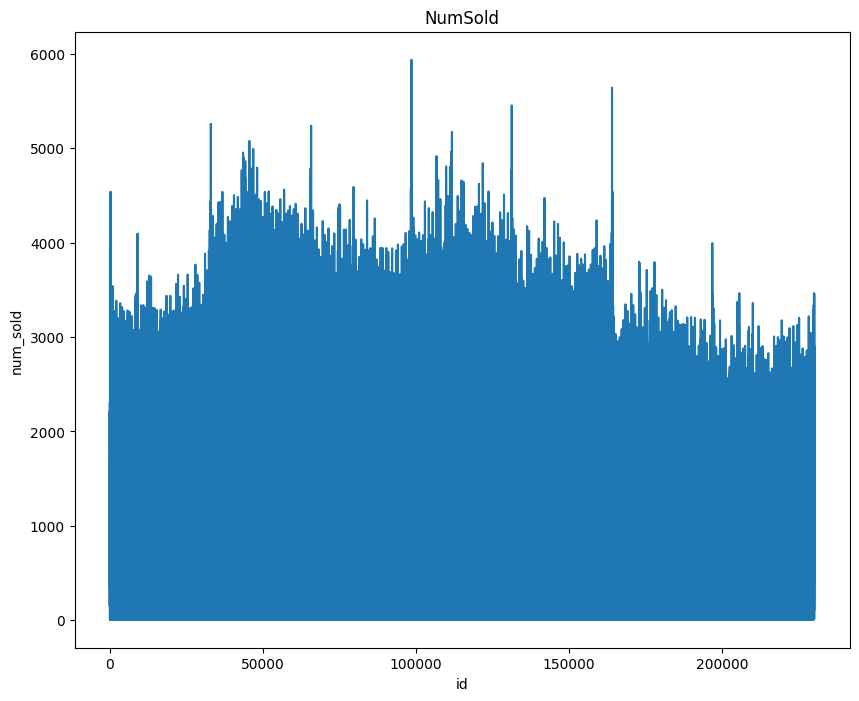

In [36]:
plt.figure(figsize=(10,8))
sns.lineplot(data=df,x='id',y='num_sold')
plt.title('NumSold')
plt.show()

In [37]:
# Seleccionar columnas de tipo str (texto) en Polars
string_columns = df.schema  # Obtiene el esquema del DataFrame
string_columns = [col for col, dtype in string_columns.items() if dtype == pl.Utf8]

# Mostrar las columnas de tipo string
print(string_columns)

['country', 'store', 'product']


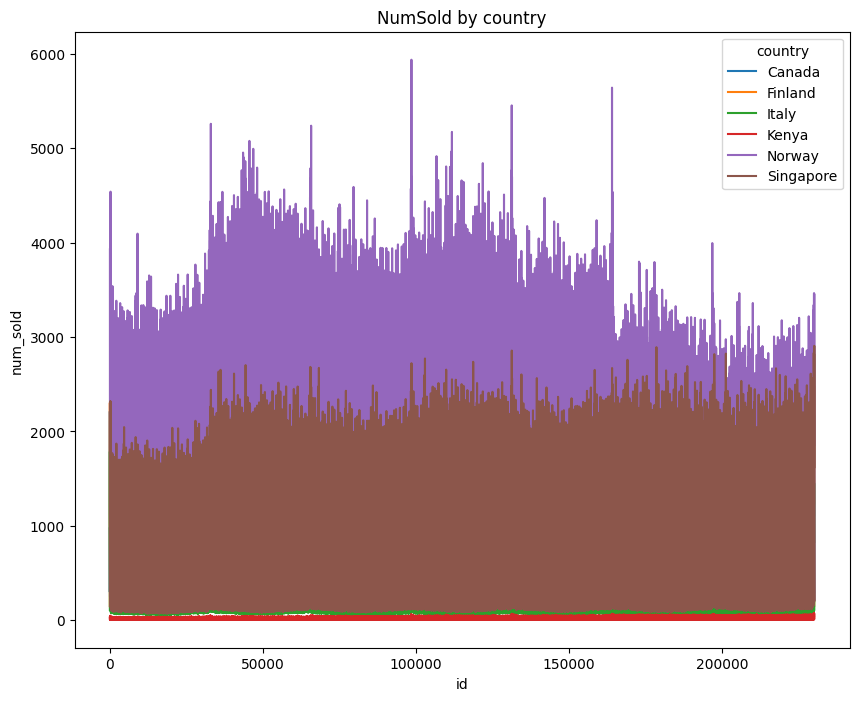

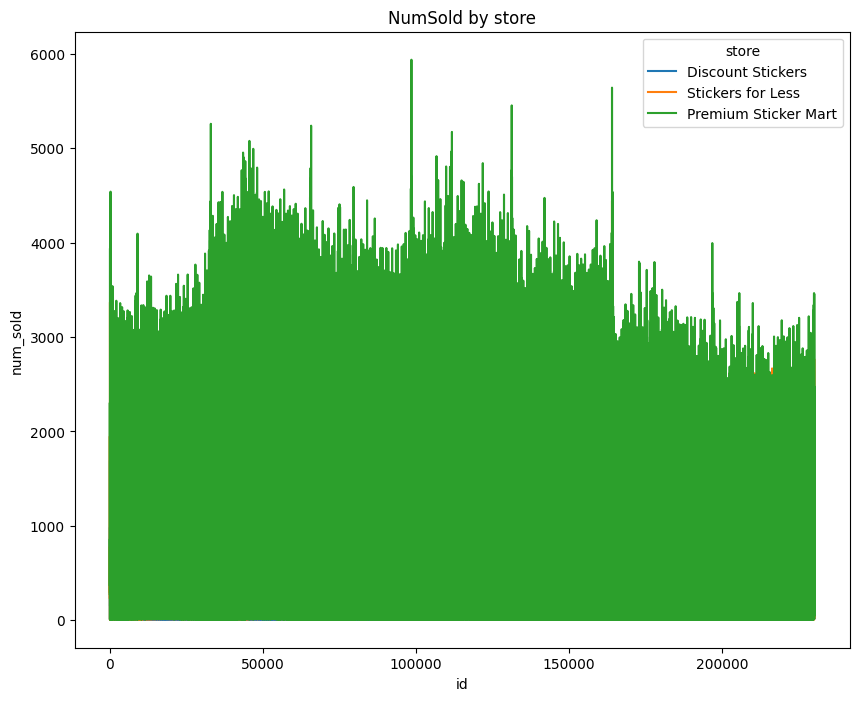

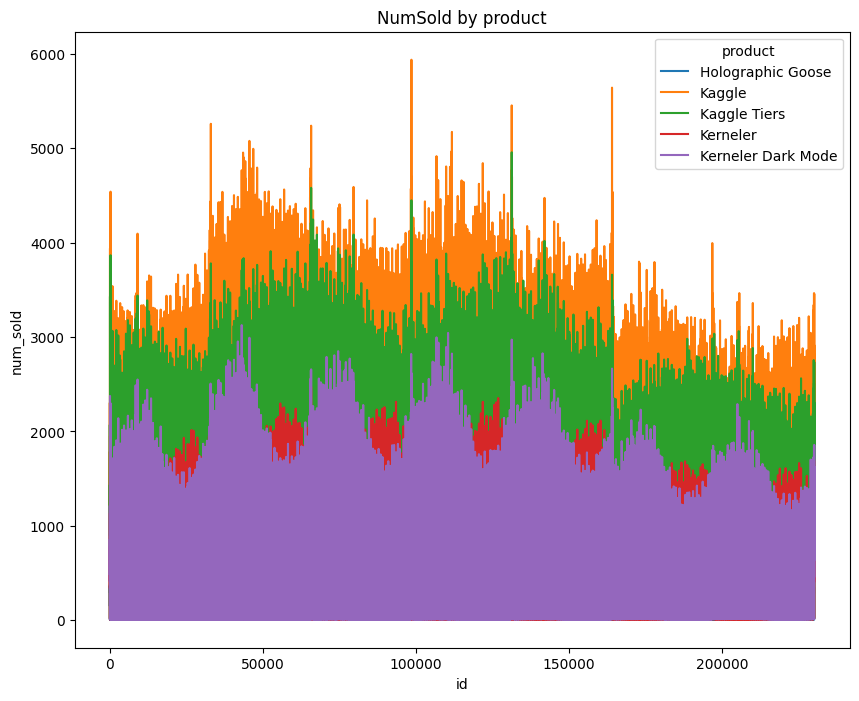

In [38]:
for i in string_columns:
    plt.figure(figsize=(10,8))
    sns.lineplot(data=df,x='id',y='num_sold', hue=i)
    plt.title(f'NumSold by {i}')
    plt.show()

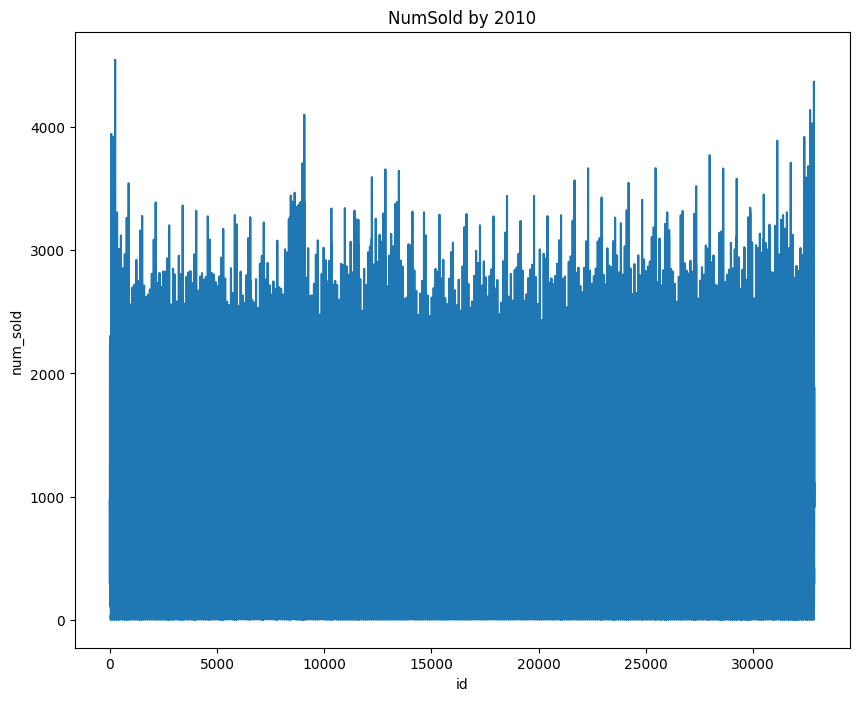

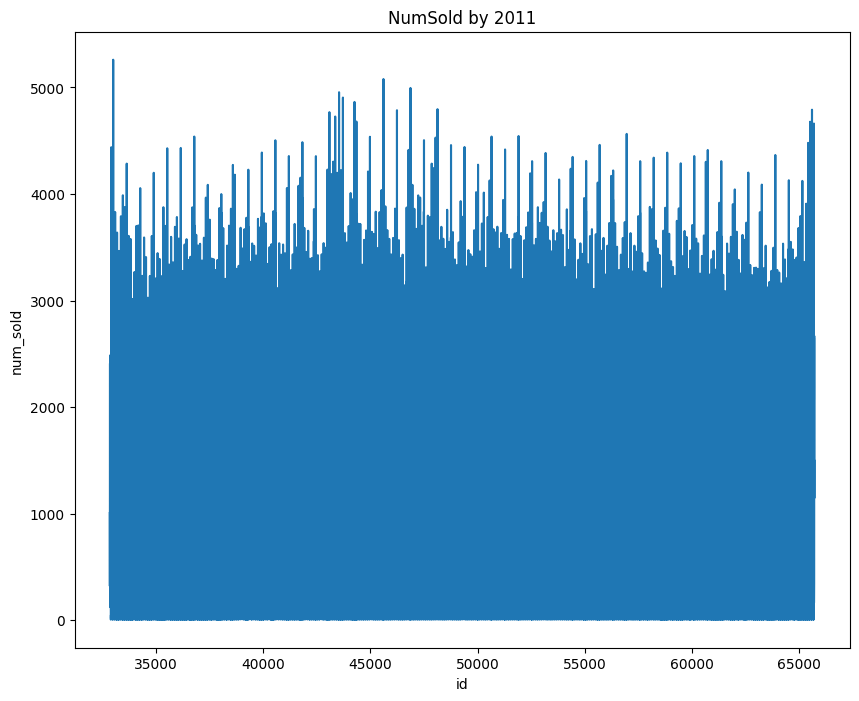

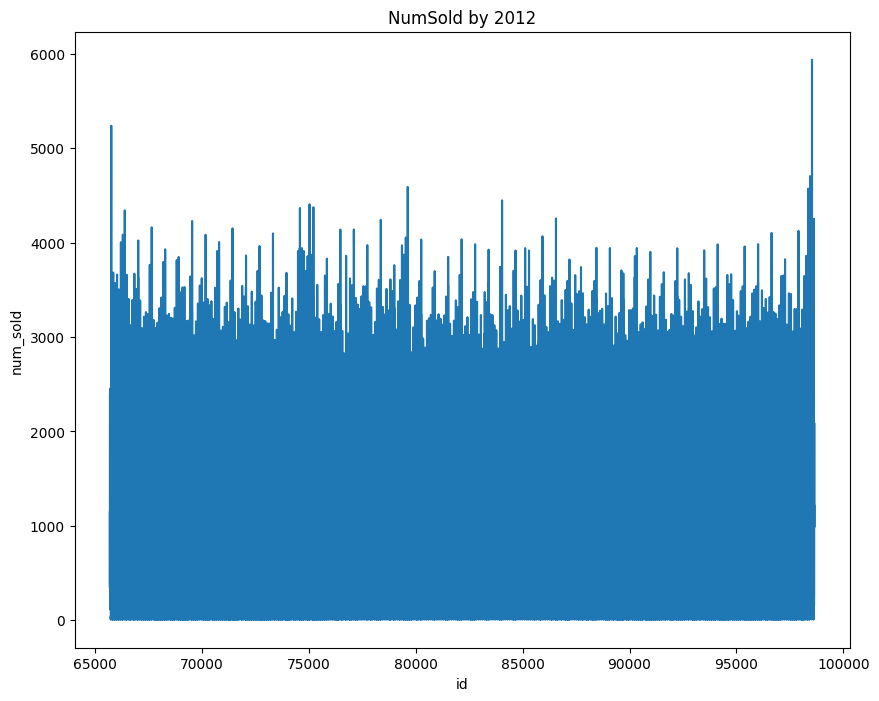

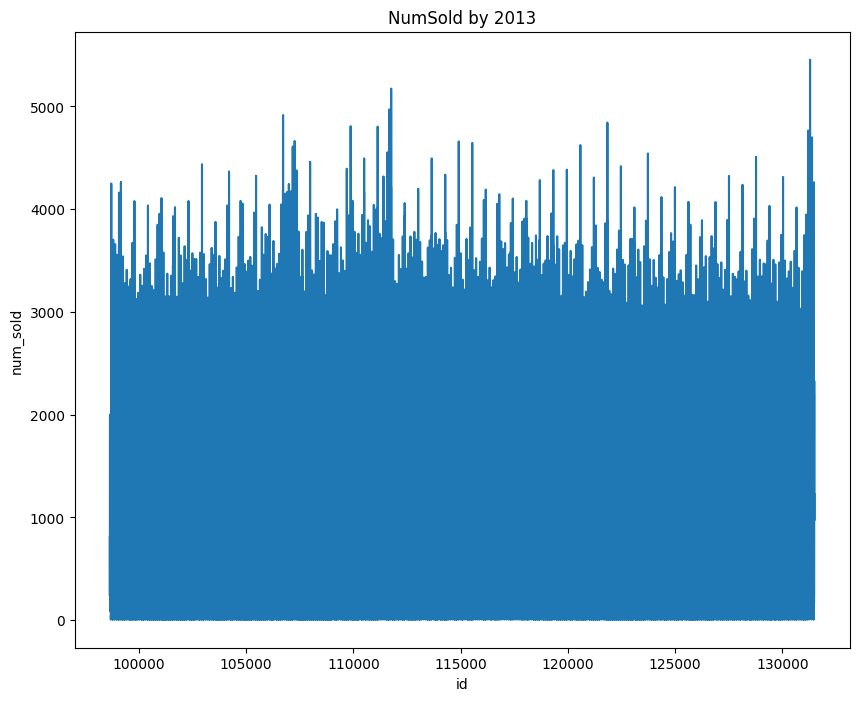

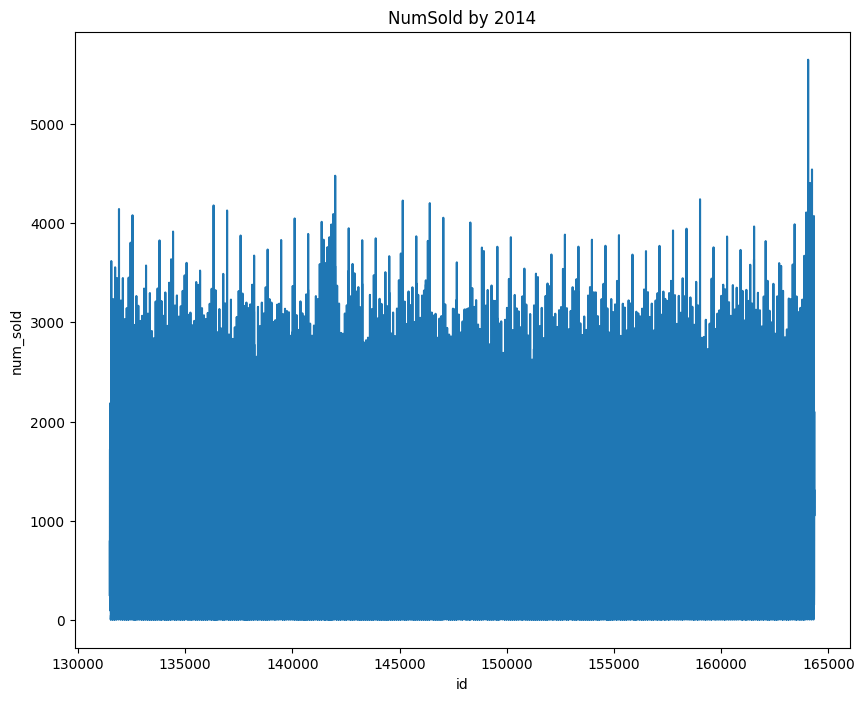

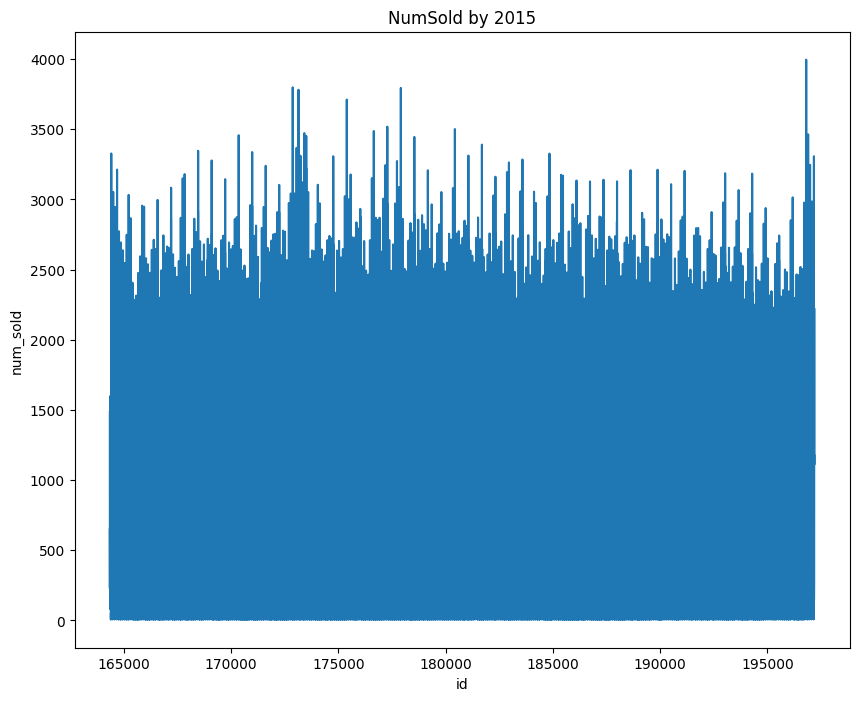

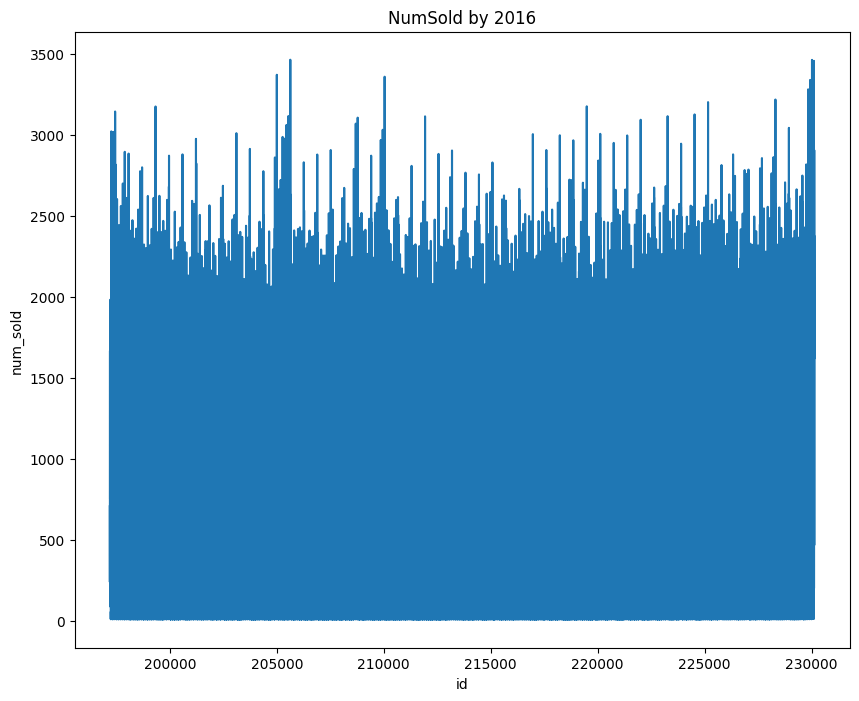

In [39]:
# Convertir la columna 'año' a tipo numérico
df = df.with_columns(pl.col("año").cast(pl.Int32))

# Lista de años para iterar
list_year=[2010,2011,2012,2013,2014,2015,2016]  # Ajusta esta lista según tus datos

# Crear gráficos para cada año
for i in list_year:
    plt.figure(figsize=(10, 8))
    sns.lineplot(data=df.filter(pl.col("año") == i).to_pandas(), x="id", y="num_sold")
    plt.title(f'NumSold by {i}')
    plt.show()

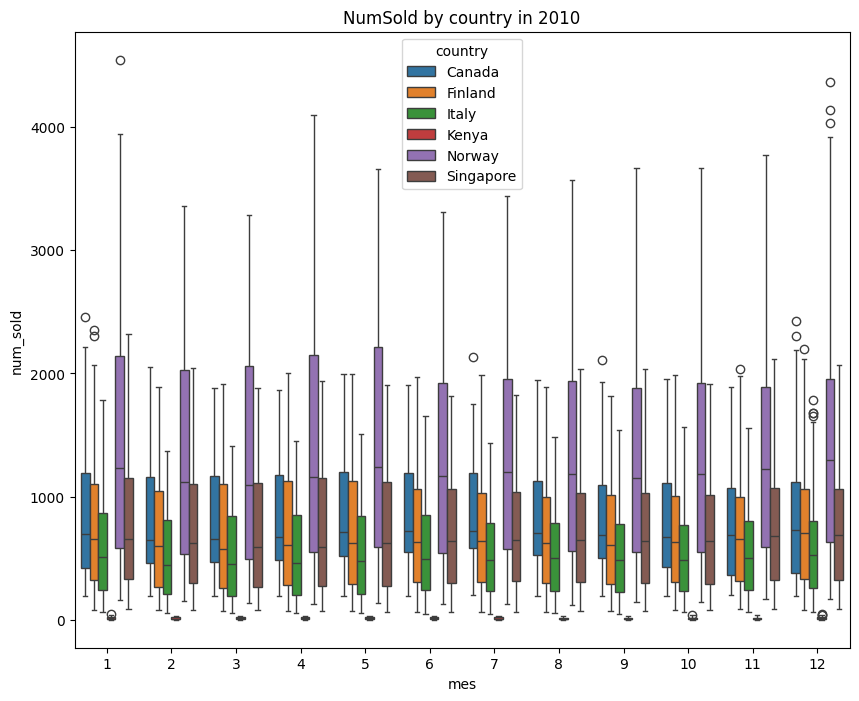

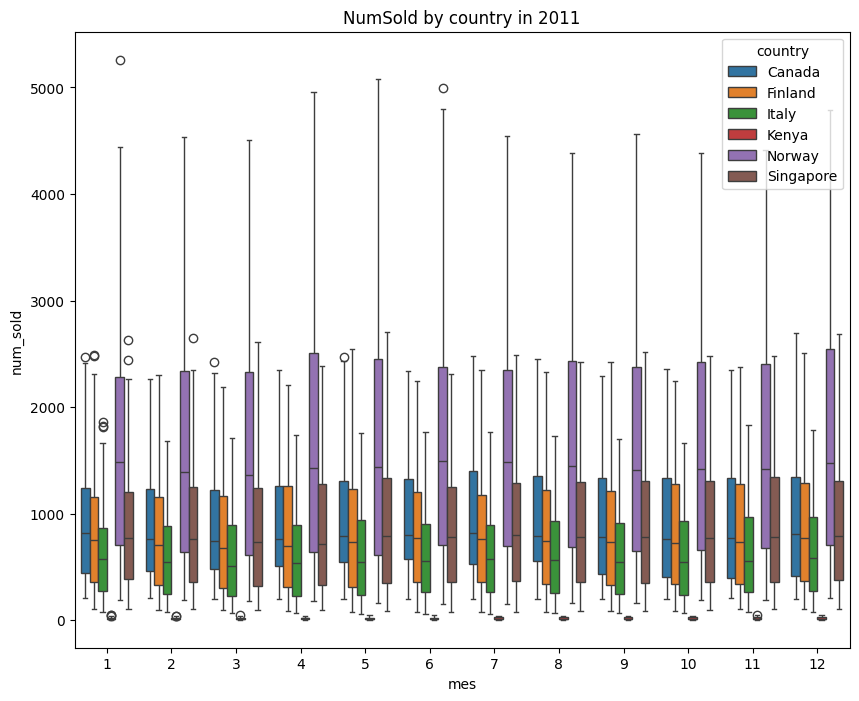

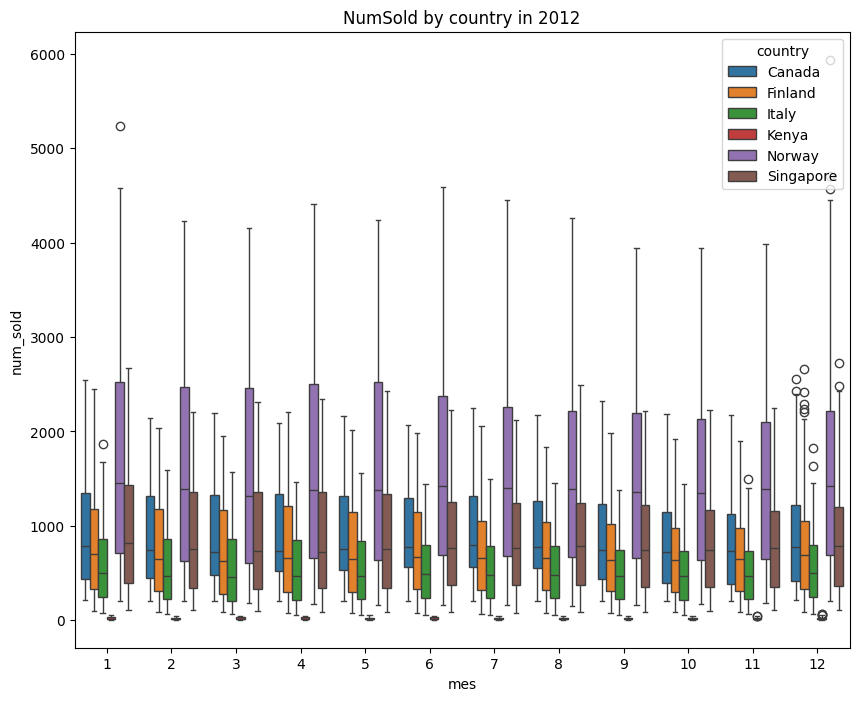

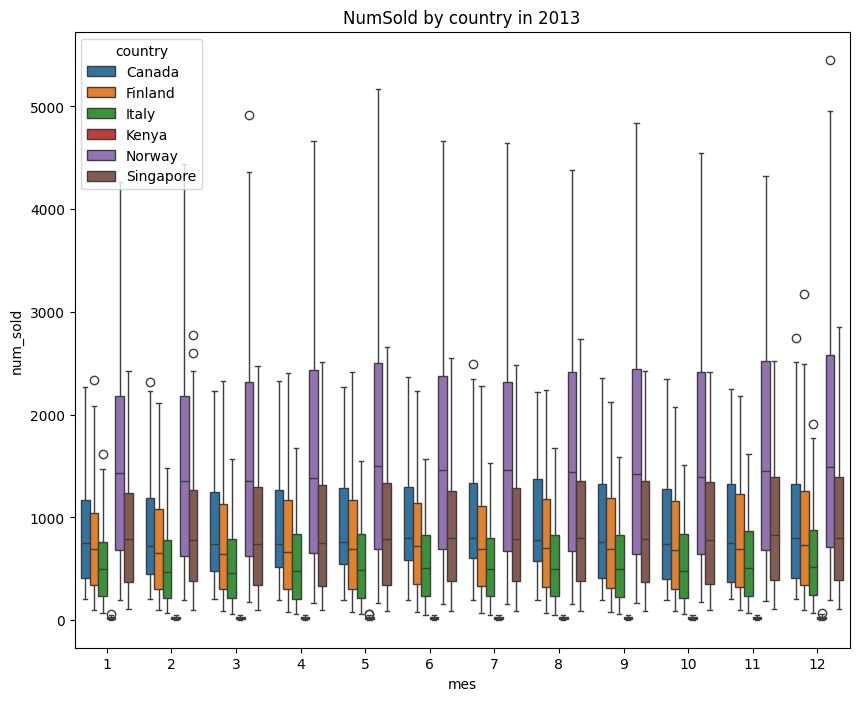

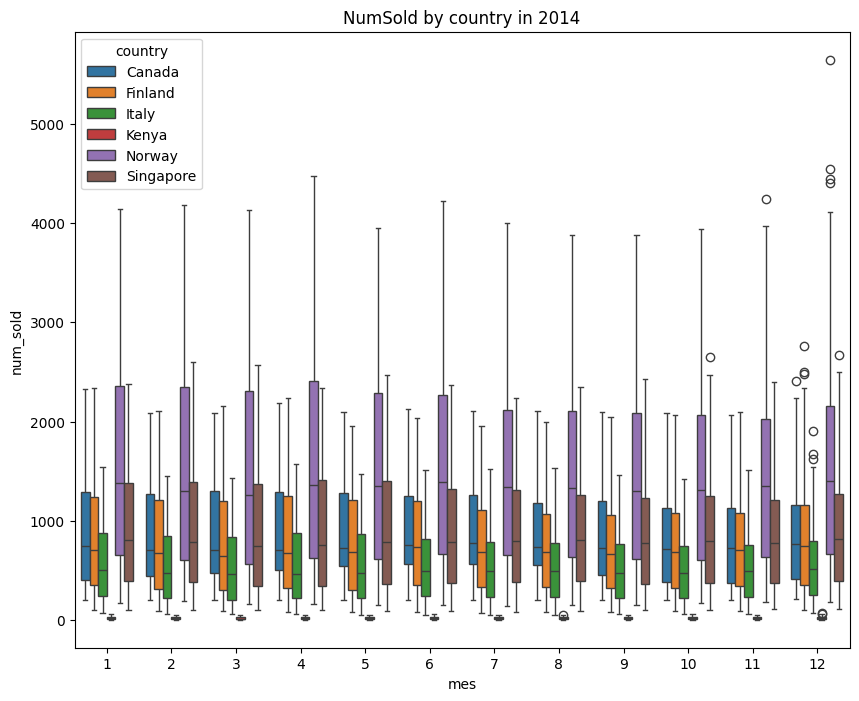

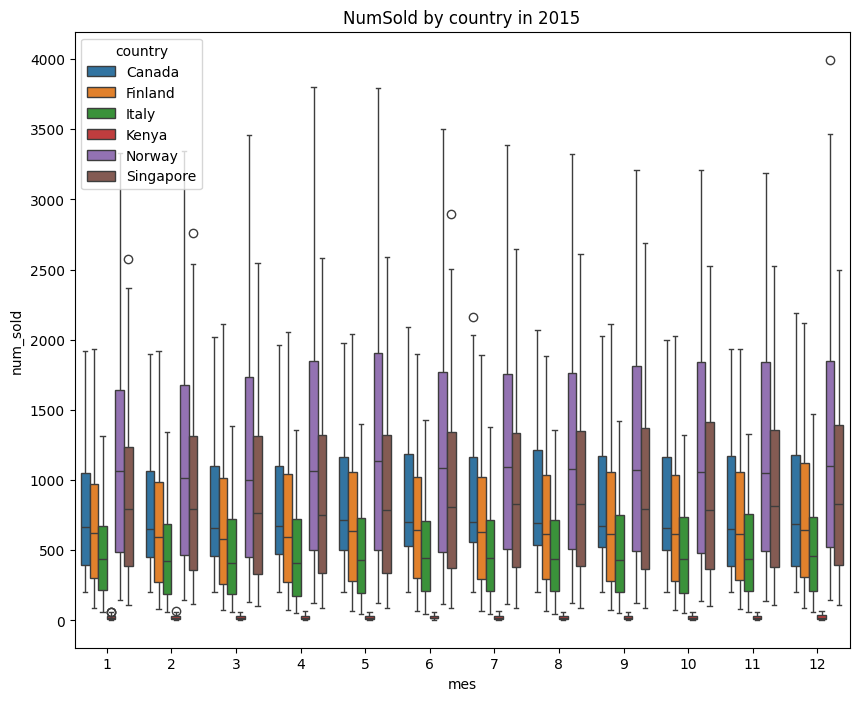

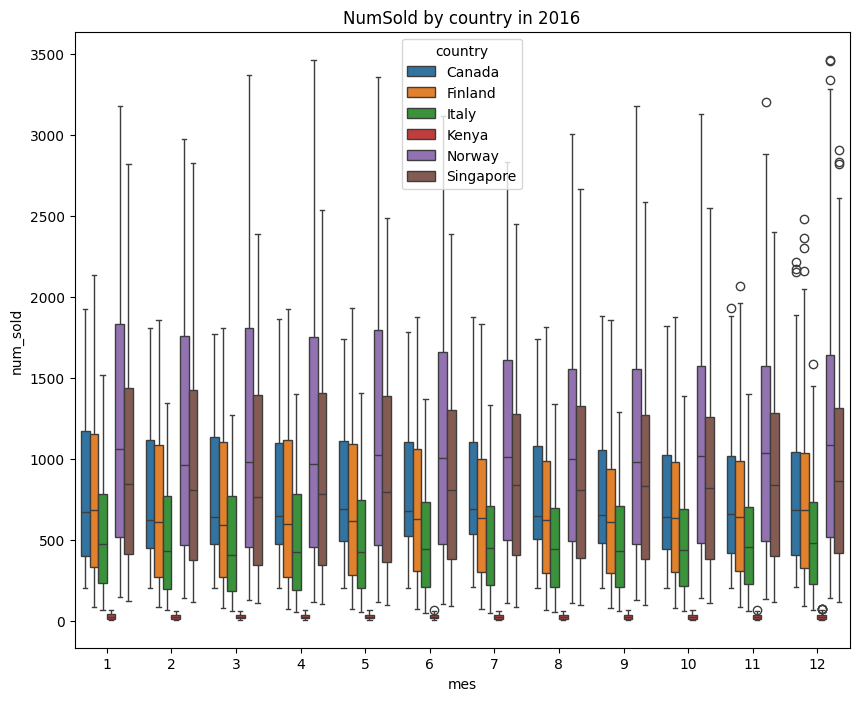

In [40]:
# Convertir la columna 'año' a tipo numérico
df = df.with_columns(pl.col("año").cast(pl.Int32))

# Lista de años para iterar
list_year=[2010,2011,2012,2013,2014,2015,2016]  # Ajusta esta lista según tus datos

# Crear gráficos para cada año
for i in list_year:
    plt.figure(figsize=(10, 8))
    sns.boxplot(data=df.filter(pl.col("año") == i).to_pandas(), x="mes", y="num_sold",hue='country')
    plt.title(f'NumSold by country in {i}')
    plt.show()

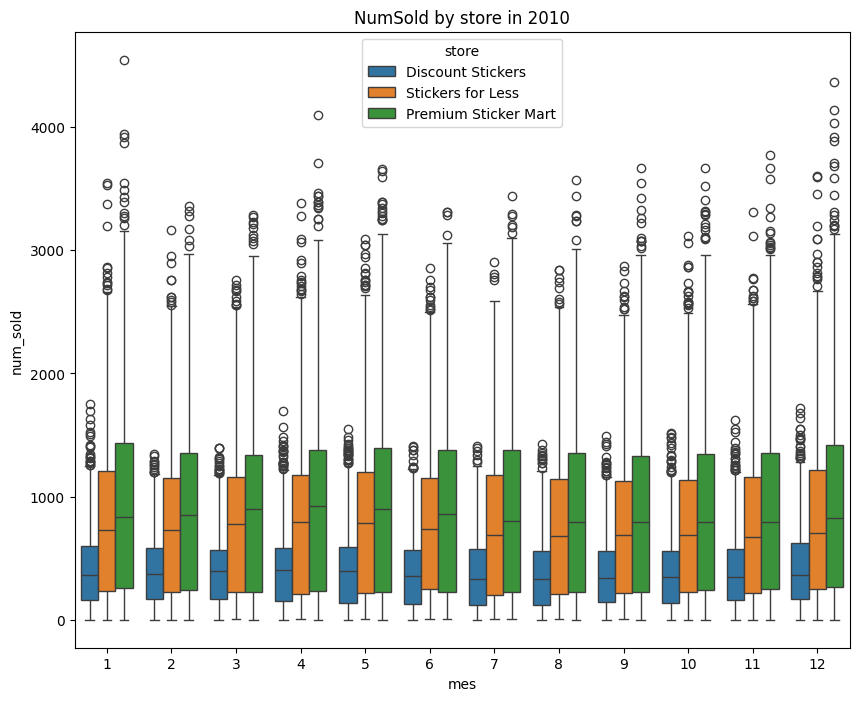

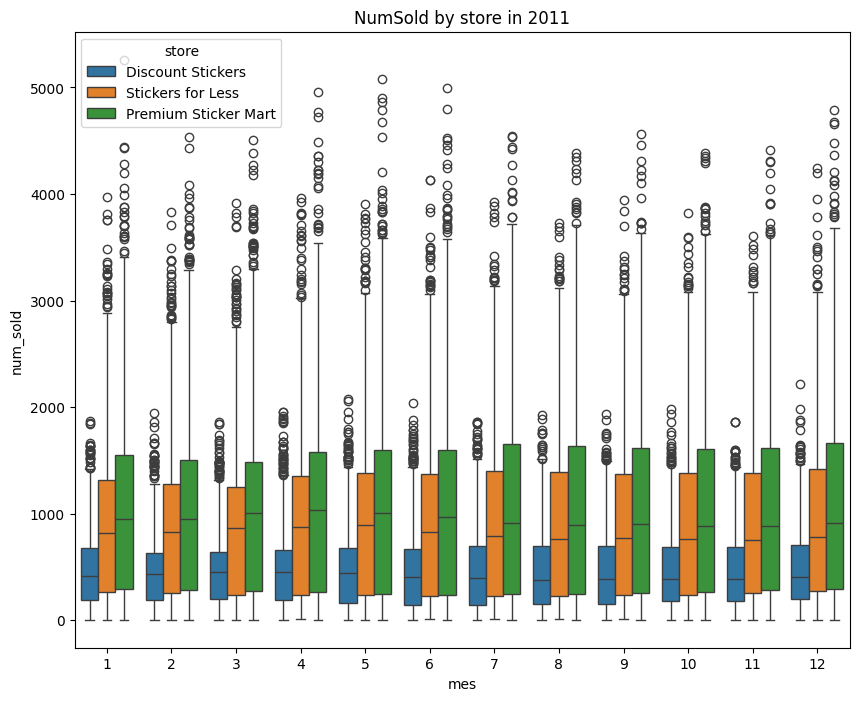

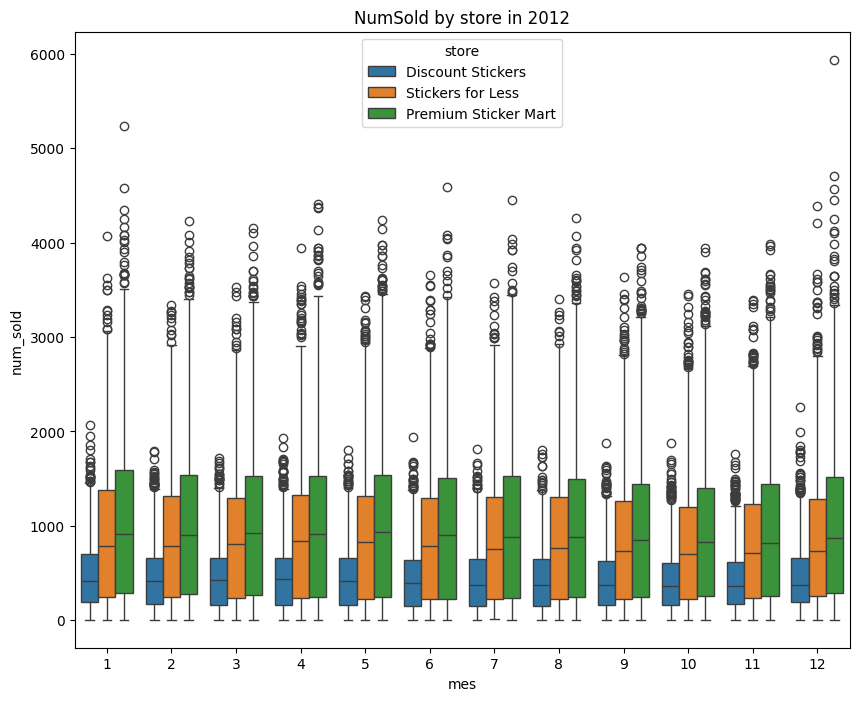

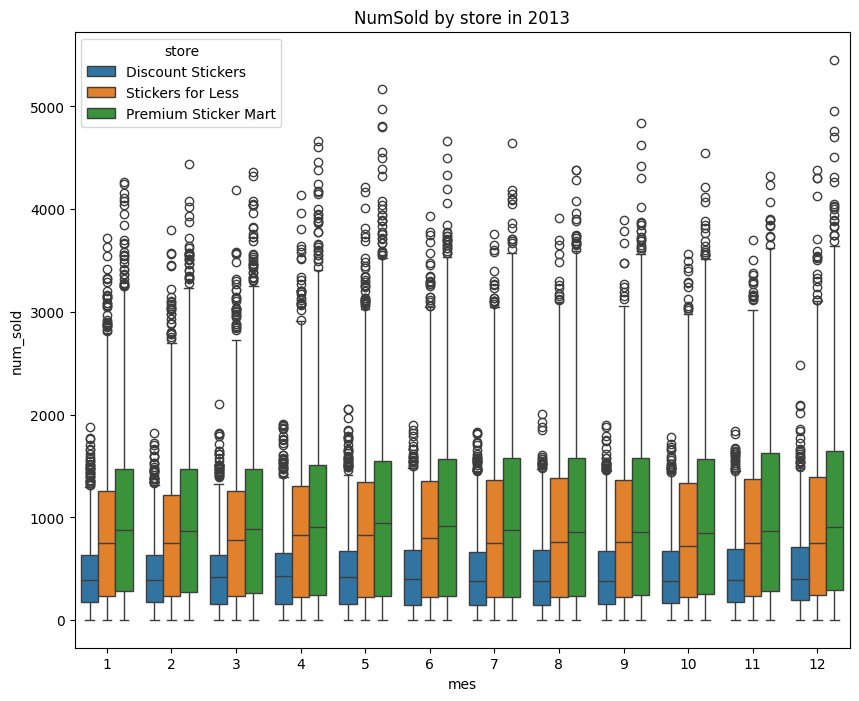

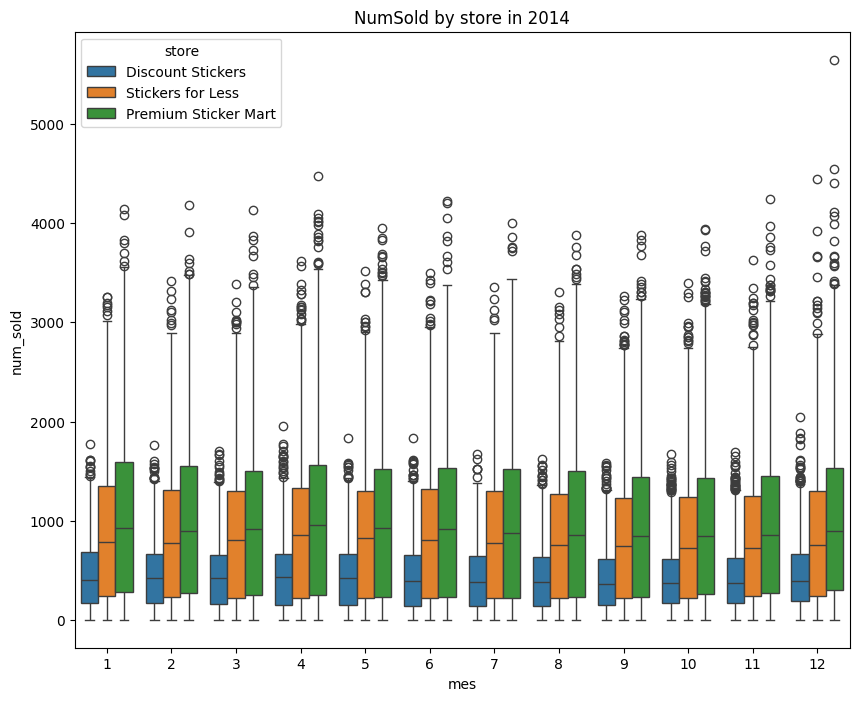

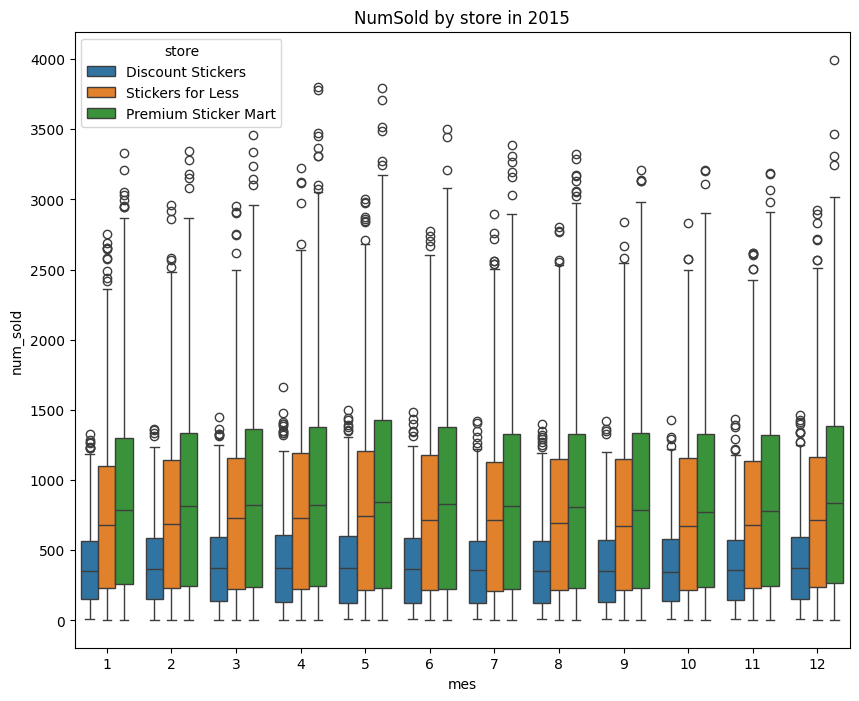

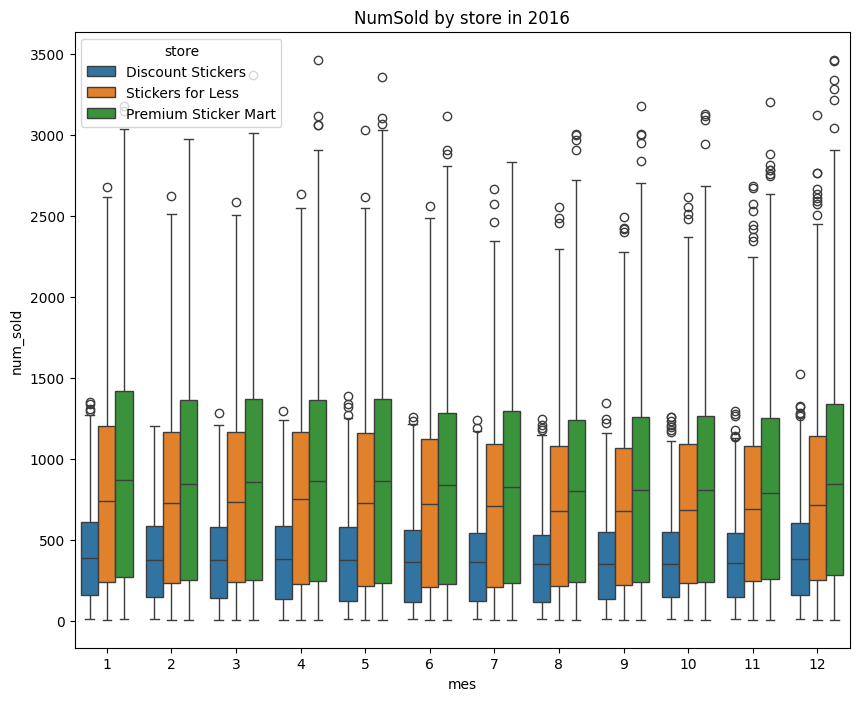

In [41]:
# Convertir la columna 'año' a tipo numérico
df = df.with_columns(pl.col("año").cast(pl.Int32))

# Lista de años para iterar
list_year=[2010,2011,2012,2013,2014,2015,2016]  # Ajusta esta lista según tus datos

# Crear gráficos para cada año
for i in list_year:
    plt.figure(figsize=(10, 8))
    sns.boxplot(data=df.filter(pl.col("año") == i).to_pandas(), x="mes", y="num_sold",hue='store')
    plt.title(f'NumSold by store in {i}')
    plt.show()

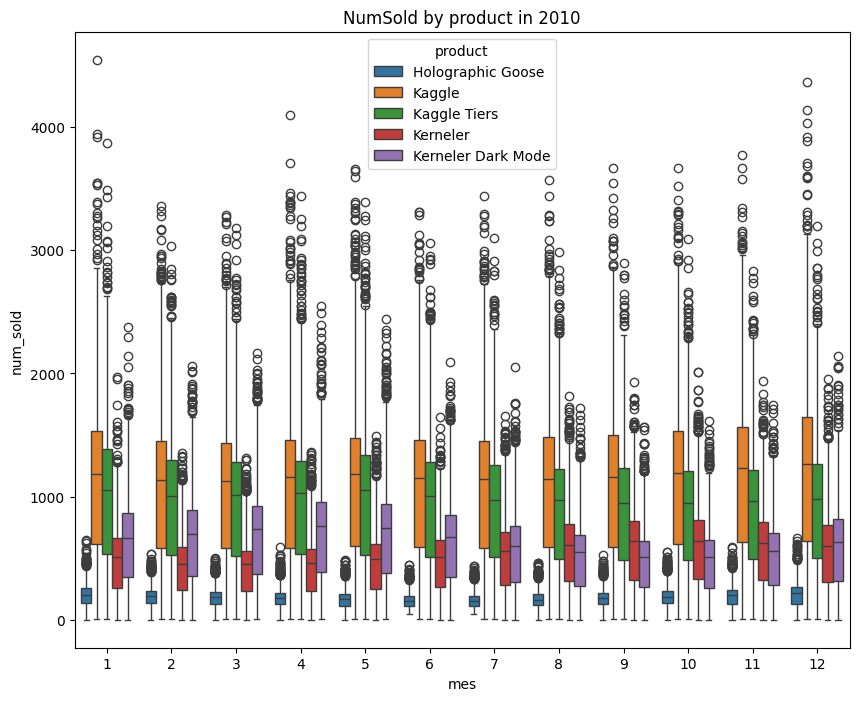

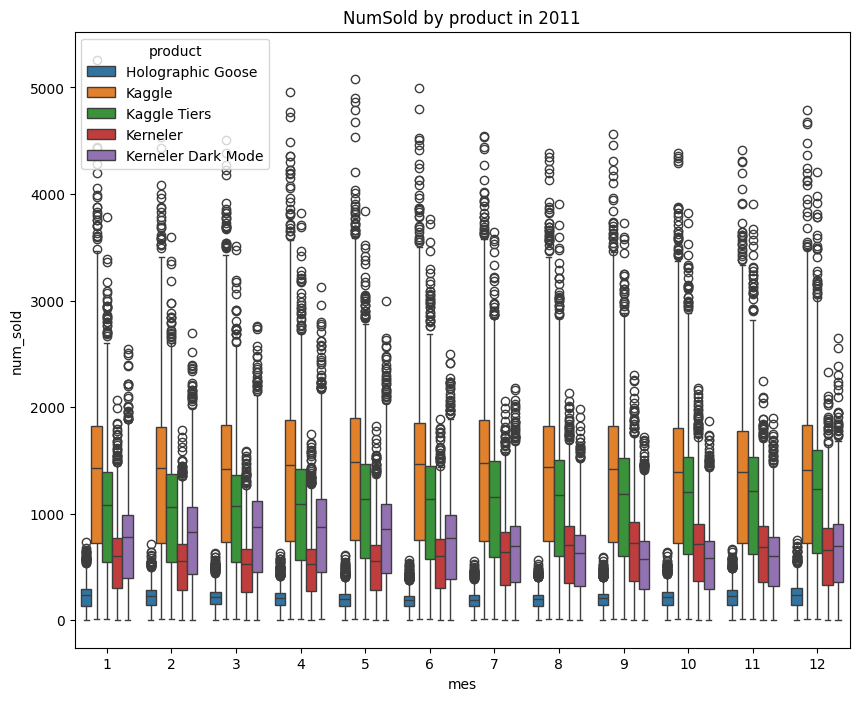

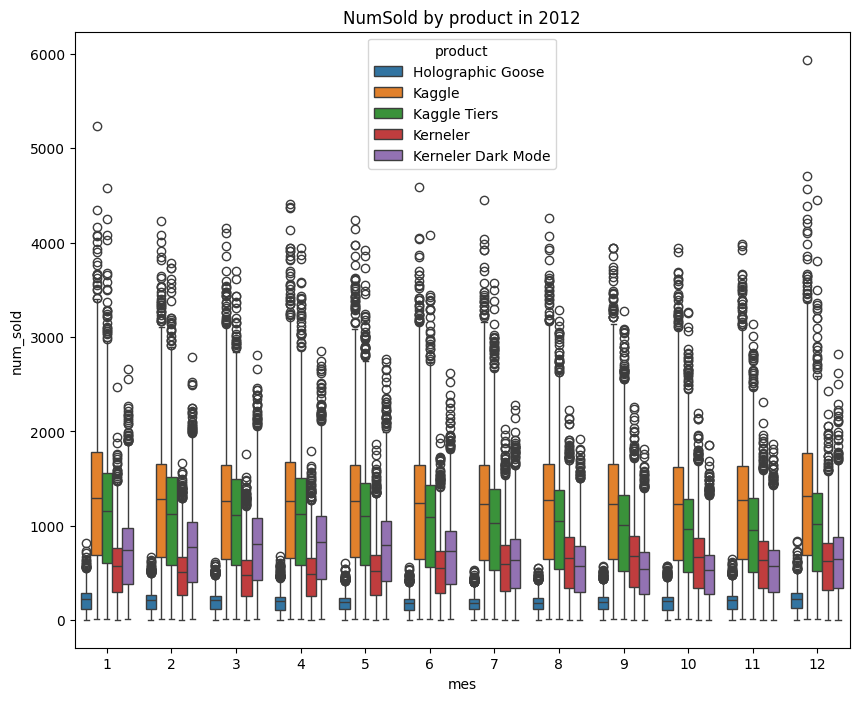

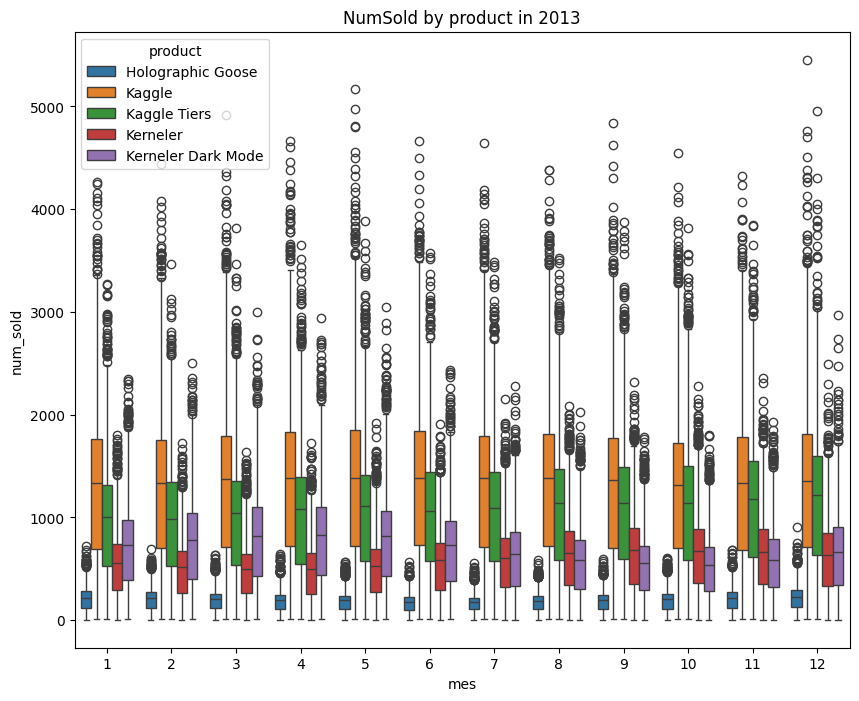

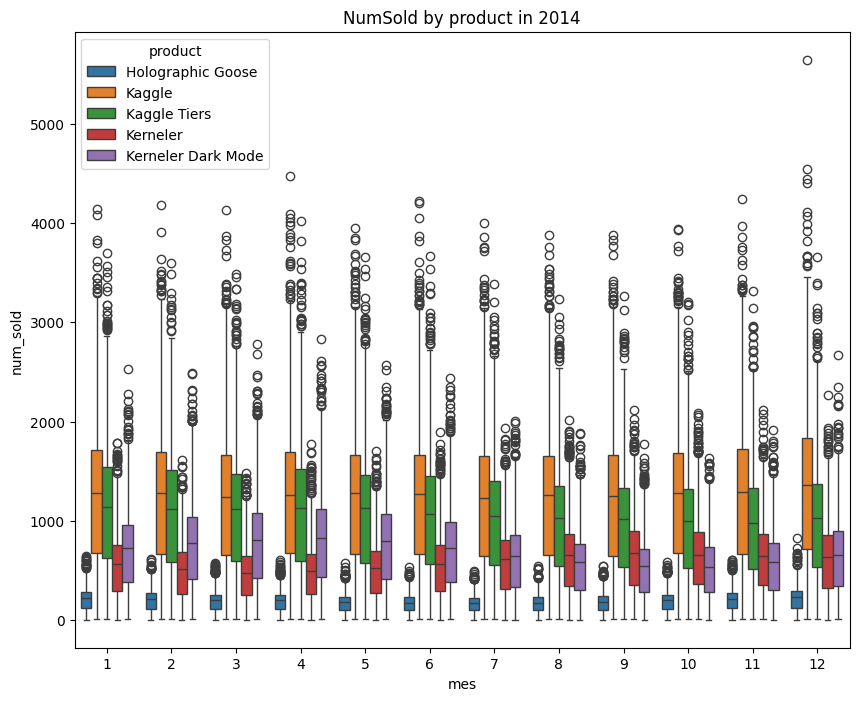

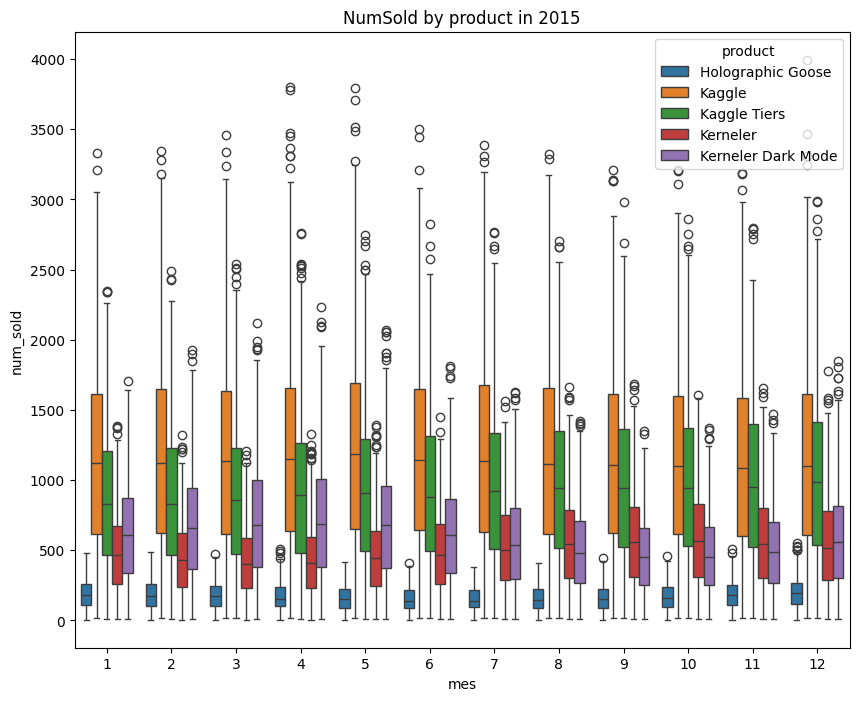

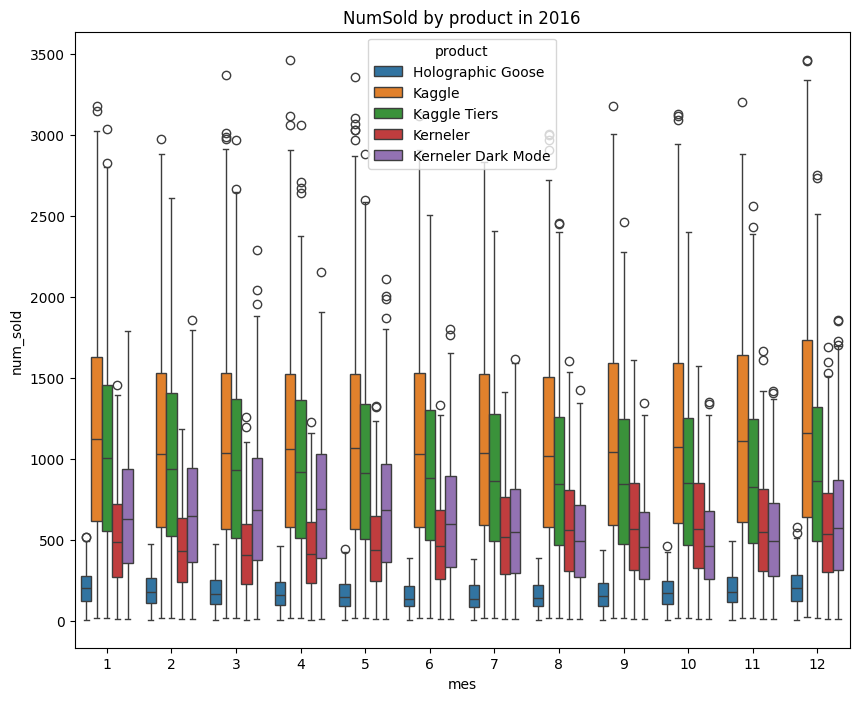

In [42]:
# Convertir la columna 'año' a tipo numérico
df = df.with_columns(pl.col("año").cast(pl.Int32))

# Lista de años para iterar
list_year=[2010,2011,2012,2013,2014,2015,2016]  # Ajusta esta lista según tus datos

# Crear gráficos para cada año
for i in list_year:
    plt.figure(figsize=(10, 8))
    sns.boxplot(data=df.filter(pl.col("año") == i).to_pandas(), x="mes", y="num_sold",hue='product')
    plt.title(f'NumSold by product in {i}')
    plt.show()

In [43]:
# Contar valores nulos en la columna 'date'
null_count = df.select(pl.col("num_sold").is_null().sum()).item()
print(f"Número de valores nulos en sold': {null_count}")

Número de valores nulos en sold': 8871


In [44]:
# Eliminar filas donde 'num_sold' es nulo
df = df.filter(pl.col("num_sold").is_not_null())

# Mostrar el DataFrame después de eliminar los nulos
print(df)

shape: (221_259, 11)
┌────────┬────────────┬───────────┬──────────────────────┬───┬─────┬──────┬────────┬───────────┐
│ id     ┆ date       ┆ country   ┆ store                ┆ … ┆ mes ┆ año  ┆ Cuatri ┆ Dayofweek │
│ ---    ┆ ---        ┆ ---       ┆ ---                  ┆   ┆ --- ┆ ---  ┆ ---    ┆ ---       │
│ i64    ┆ date       ┆ str       ┆ str                  ┆   ┆ i8  ┆ i32  ┆ i8     ┆ i8        │
╞════════╪════════════╪═══════════╪══════════════════════╪═══╪═════╪══════╪════════╪═══════════╡
│ 1      ┆ 2010-01-01 ┆ Canada    ┆ Discount Stickers    ┆ … ┆ 1   ┆ 2010 ┆ 1      ┆ 5         │
│ 2      ┆ 2010-01-01 ┆ Canada    ┆ Discount Stickers    ┆ … ┆ 1   ┆ 2010 ┆ 1      ┆ 5         │
│ 3      ┆ 2010-01-01 ┆ Canada    ┆ Discount Stickers    ┆ … ┆ 1   ┆ 2010 ┆ 1      ┆ 5         │
│ 4      ┆ 2010-01-01 ┆ Canada    ┆ Discount Stickers    ┆ … ┆ 1   ┆ 2010 ┆ 1      ┆ 5         │
│ 5      ┆ 2010-01-01 ┆ Canada    ┆ Stickers for Less    ┆ … ┆ 1   ┆ 2010 ┆ 1      ┆ 5         │
│ …      

In [49]:
df.head()

shape: (5, 17)
┌─────┬────────────┬─────────┬───────────────────┬───┬───────────┬───────────┬──────────┬──────────┐
│ id  ┆ date       ┆ country ┆ store             ┆ … ┆ Month_Sin ┆ Month_Cos ┆ Year_Sin ┆ Year_Cos │
│ --- ┆ ---        ┆ ---     ┆ ---               ┆   ┆ ---       ┆ ---       ┆ ---      ┆ ---      │
│ i64 ┆ date       ┆ str     ┆ str               ┆   ┆ f64       ┆ f64       ┆ f64      ┆ f64      │
╞═════╪════════════╪═════════╪═══════════════════╪═══╪═══════════╪═══════════╪══════════╪══════════╡
│ 1   ┆ 2010-01-01 ┆ Canada  ┆ Discount Stickers ┆ … ┆ 0.5       ┆ 0.866025  ┆ 0.781831 ┆ 0.62349  │
│ 2   ┆ 2010-01-01 ┆ Canada  ┆ Discount Stickers ┆ … ┆ 0.5       ┆ 0.866025  ┆ 0.781831 ┆ 0.62349  │
│ 3   ┆ 2010-01-01 ┆ Canada  ┆ Discount Stickers ┆ … ┆ 0.5       ┆ 0.866025  ┆ 0.781831 ┆ 0.62349  │
│ 4   ┆ 2010-01-01 ┆ Canada  ┆ Discount Stickers ┆ … ┆ 0.5       ┆ 0.866025  ┆ 0.781831 ┆ 0.62349  │
│ 5   ┆ 2010-01-01 ┆ Canada  ┆ Stickers for Less ┆ … ┆ 0.5       ┆ 0.866025  ┆ 0.781831 ┆ 0.62349  │
└─────┴────────────┴─────────┴───────────────────┴───┴───────────┴───────────┴──────────┴──────────┘

In [50]:
df[['date','product','num_sold']].head()

shape: (5, 3)
┌────────────┬────────────────────┬──────────┐
│ date       ┆ product            ┆ num_sold │
│ ---        ┆ ---                ┆ ---      │
│ date       ┆ str                ┆ f64      │
╞════════════╪════════════════════╪══════════╡
│ 2010-01-01 ┆ Kaggle             ┆ 973.0    │
│ 2010-01-01 ┆ Kaggle Tiers       ┆ 906.0    │
│ 2010-01-01 ┆ Kerneler           ┆ 423.0    │
│ 2010-01-01 ┆ Kerneler Dark Mode ┆ 491.0    │
│ 2010-01-01 ┆ Holographic Goose  ┆ 300.0    │
└────────────┴────────────────────┴──────────┘

In [57]:
result = df.group_by(["date", "product"]).agg(
    pl.col("num_sold").mean().alias("avg_num_sold")
)
# Ordenar por fecha
result= result.sort("date")
# Mostrar el resultado
print(result)

shape: (12_785, 3)
┌────────────┬────────────────────┬──────────────┐
│ date       ┆ product            ┆ avg_num_sold │
│ ---        ┆ ---                ┆ ---          │
│ date       ┆ str                ┆ f64          │
╞════════════╪════════════════════╪══════════════╡
│ 2010-01-01 ┆ Kerneler Dark Mode ┆ 831.944444   │
│ 2010-01-01 ┆ Kaggle             ┆ 1568.055556  │
│ 2010-01-01 ┆ Kaggle Tiers       ┆ 1386.444444  │
│ 2010-01-01 ┆ Holographic Goose  ┆ 271.875      │
│ 2010-01-01 ┆ Kerneler           ┆ 725.555556   │
│ …          ┆ …                  ┆ …            │
│ 2016-12-31 ┆ Holographic Goose  ┆ 265.125      │
│ 2016-12-31 ┆ Kaggle Tiers       ┆ 1225.888889  │
│ 2016-12-31 ┆ Kerneler Dark Mode ┆ 834.0        │
│ 2016-12-31 ┆ Kaggle             ┆ 1538.944444  │
│ 2016-12-31 ┆ Kerneler           ┆ 689.333333   │
└────────────┴────────────────────┴──────────────┘


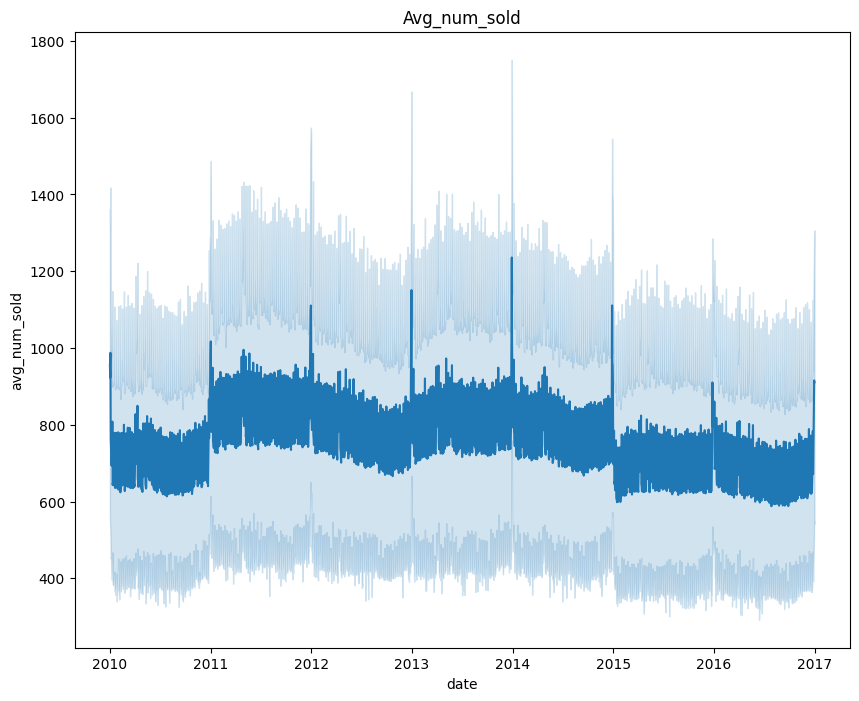

In [59]:
plt.figure(figsize=(10,8))
sns.lineplot(data=result,x='date',y='avg_num_sold')
plt.title('Avg_num_sold')
plt.show()

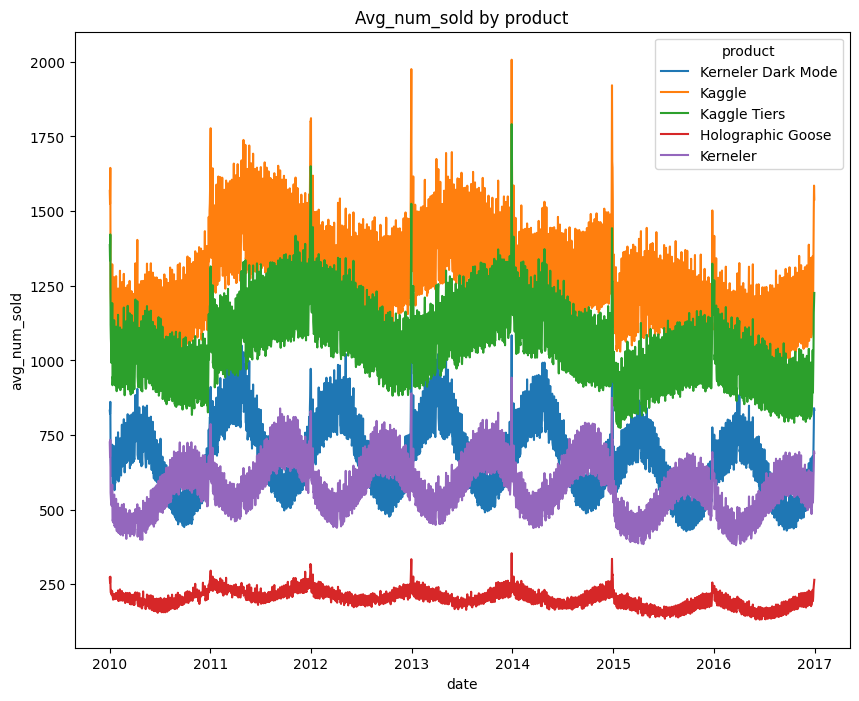

In [60]:
plt.figure(figsize=(10,8))
sns.lineplot(data=result,x='date',y='avg_num_sold',hue='product')
plt.title('Avg_num_sold by product')
plt.show()

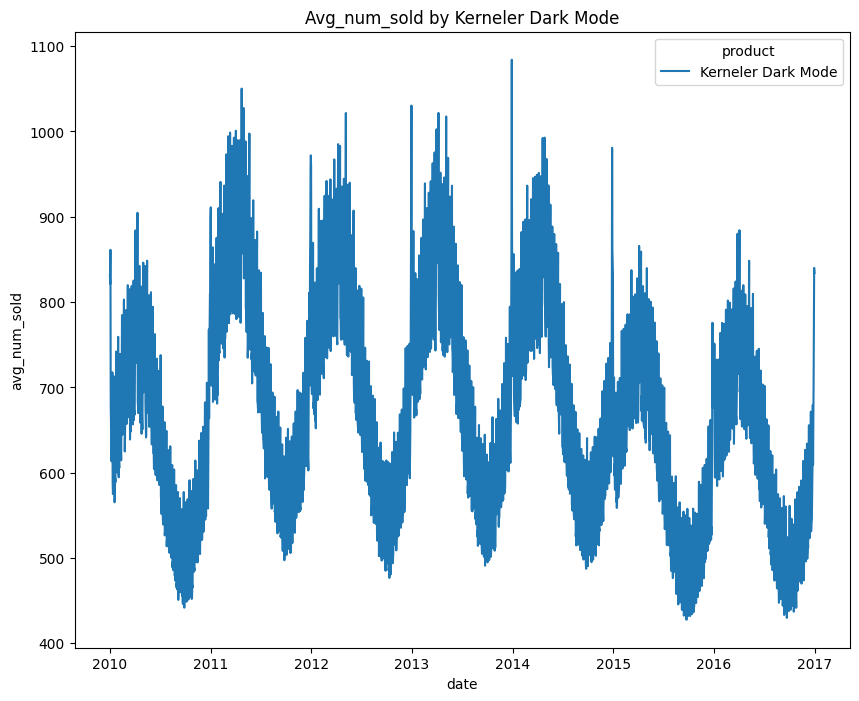

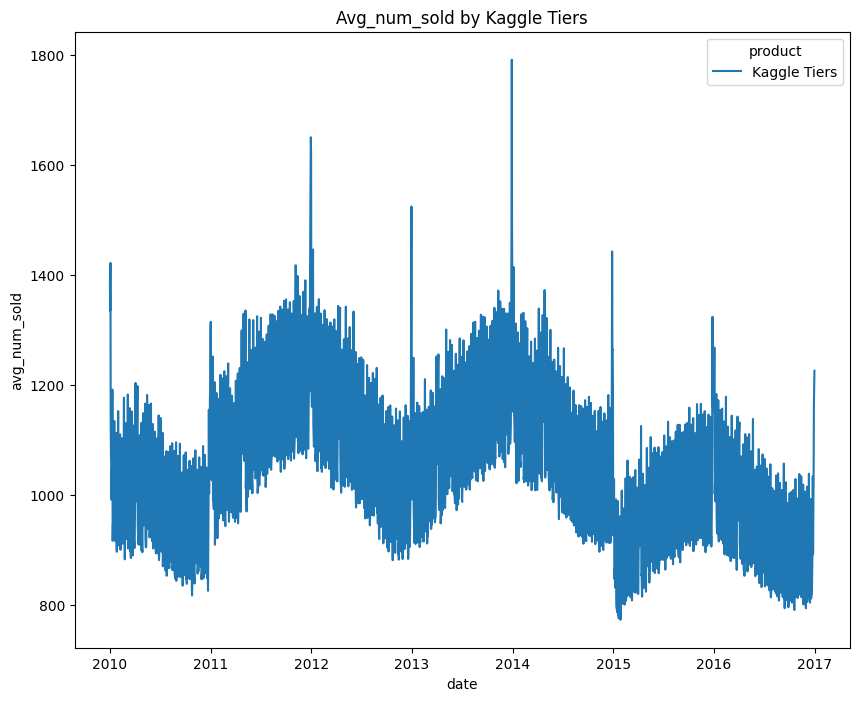

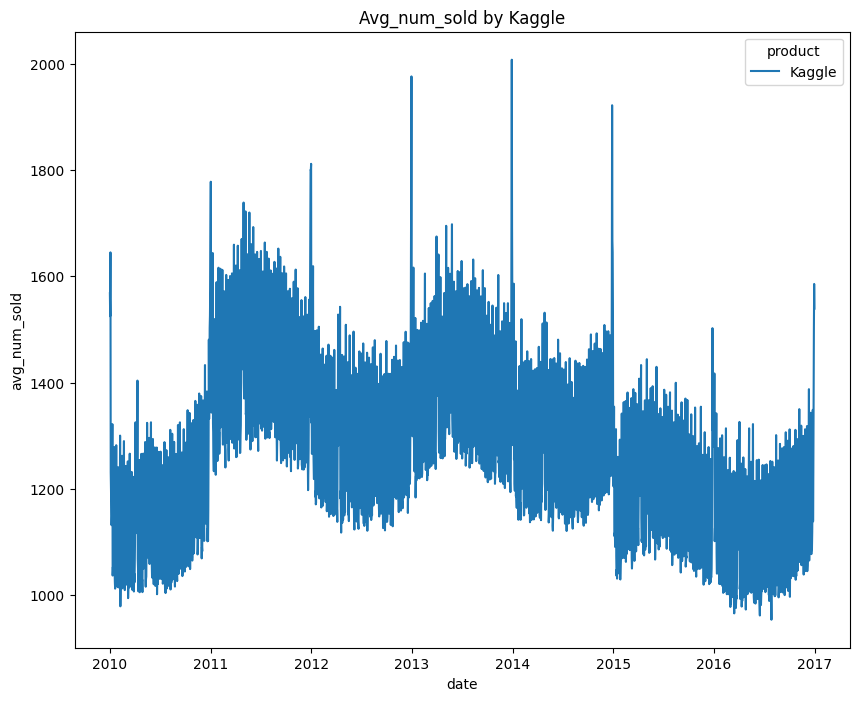

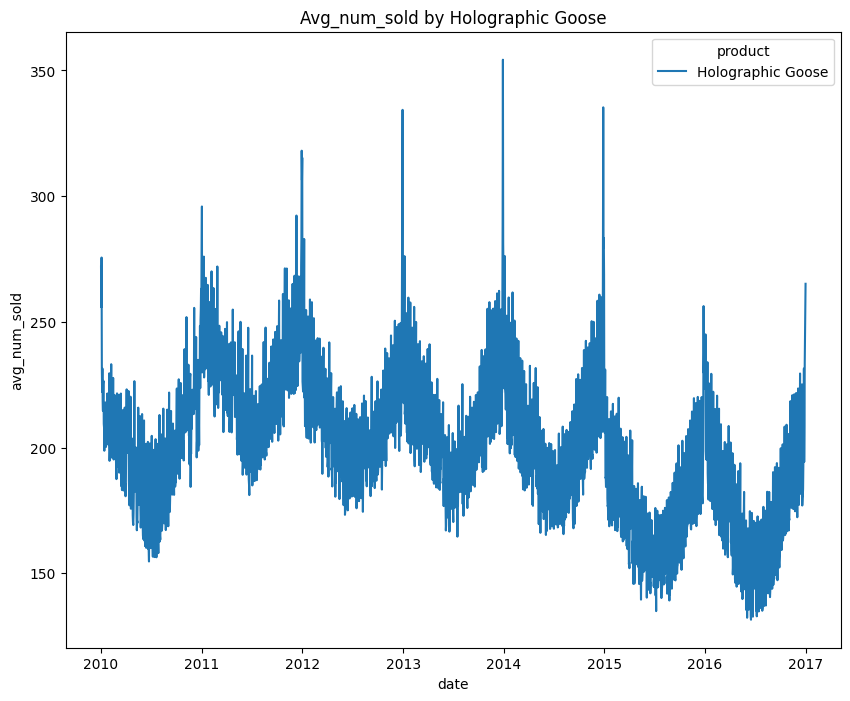

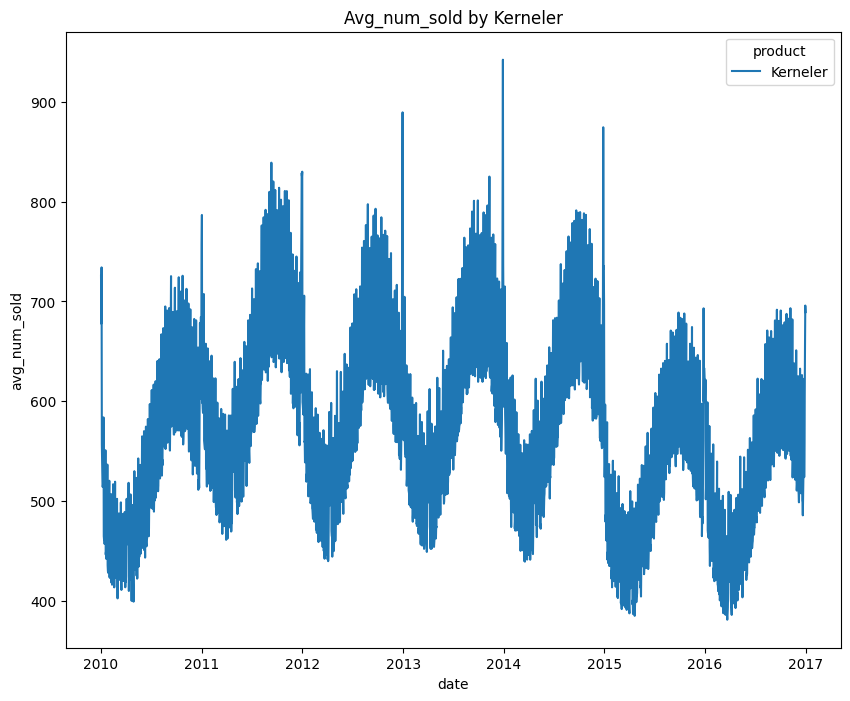

In [68]:
prod=['Kerneler Dark Mode','Kaggle Tiers','Kaggle','Holographic Goose','Kerneler']
for i in prod:
    plt.figure(figsize=(10,8))
    sns.lineplot(data=result.filter(pl.col("product") == i),x='date',y='avg_num_sold',hue='product')
    plt.title(f'Avg_num_sold by {i}')
    plt.show()

In [69]:
result=result.with_columns(
    [
        pl.col("date").dt.year().alias("año"),  # Extraer el año
    ]
)

In [ ]:
prod=['Kerneler Dark Mode','Kaggle Tiers','Kaggle','Holographic Goose','Kerneler']
for i in prod:
    plt.figure(figsize=(10,8))
    sns.lineplot(data=result.filter(pl.col("product") == i),x='date',y='avg_num_sold',hue='product')
    plt.title(f'Avg_num_sold by {i}')
    plt.show()

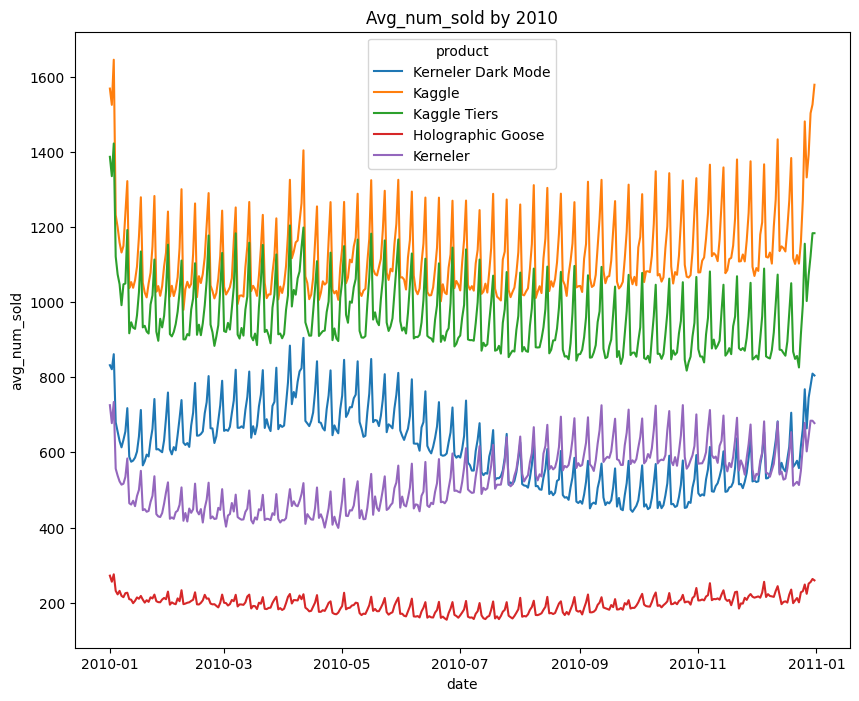

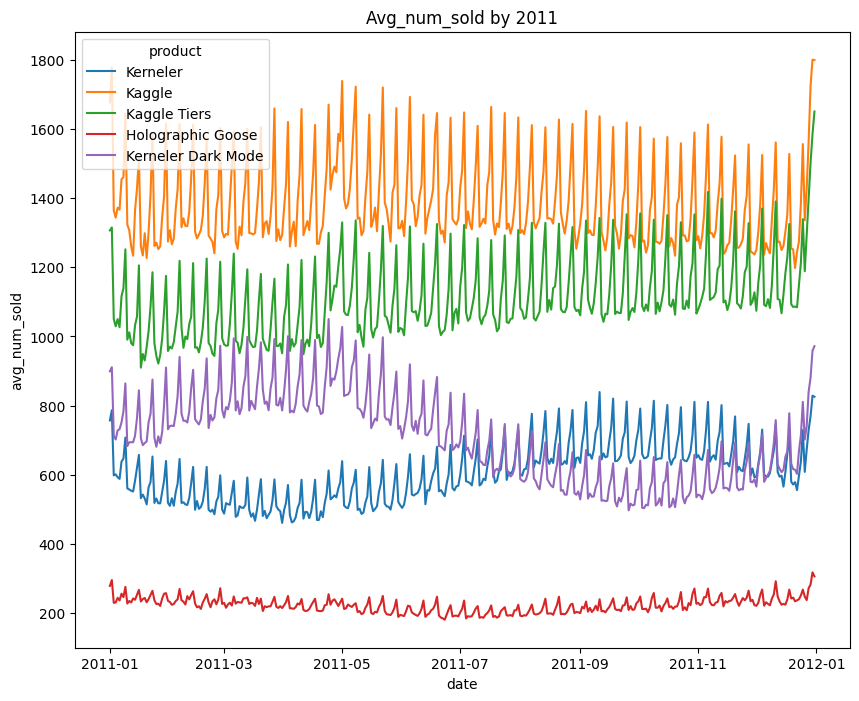

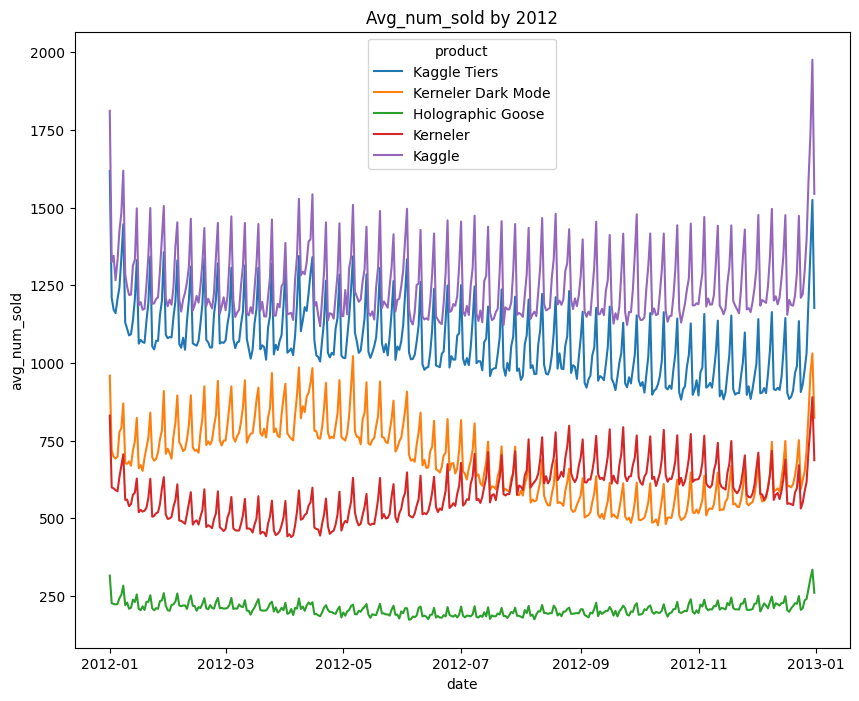

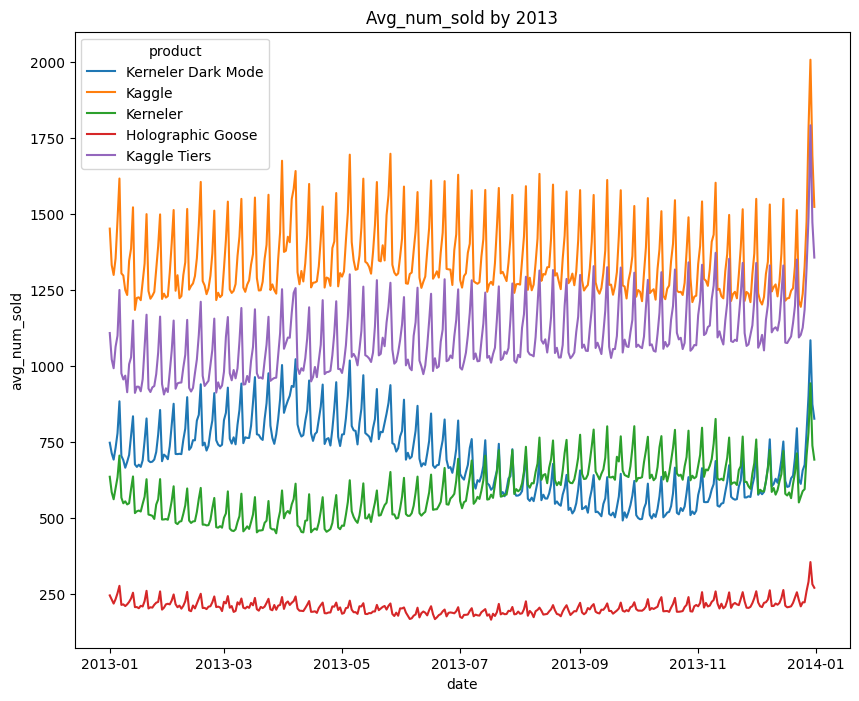

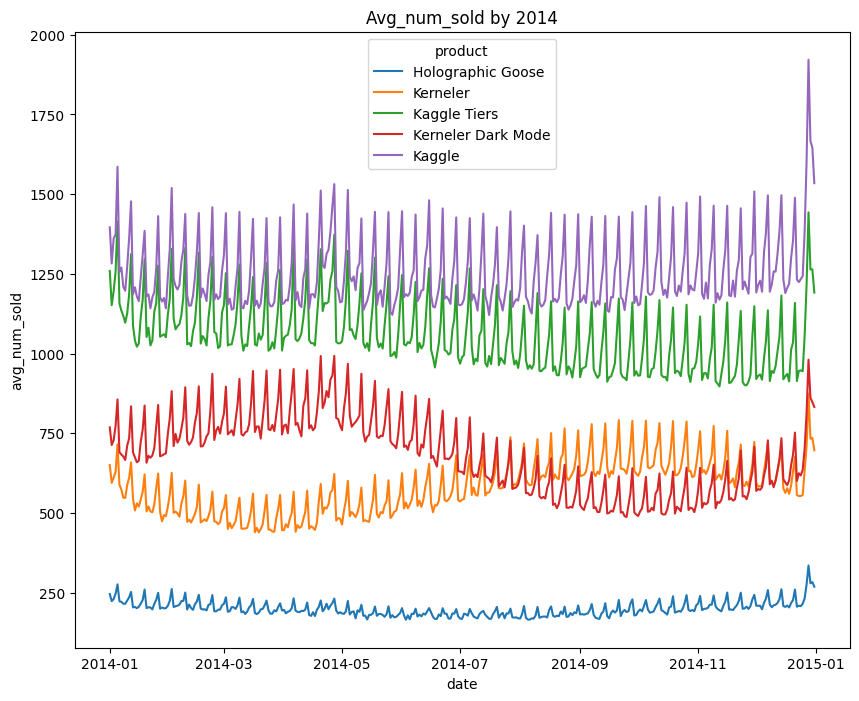

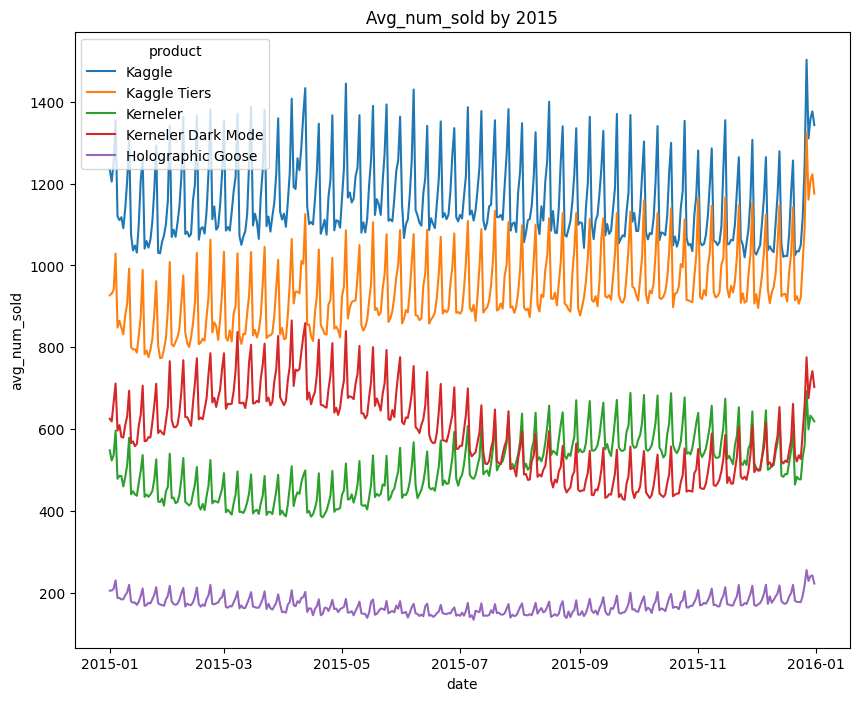

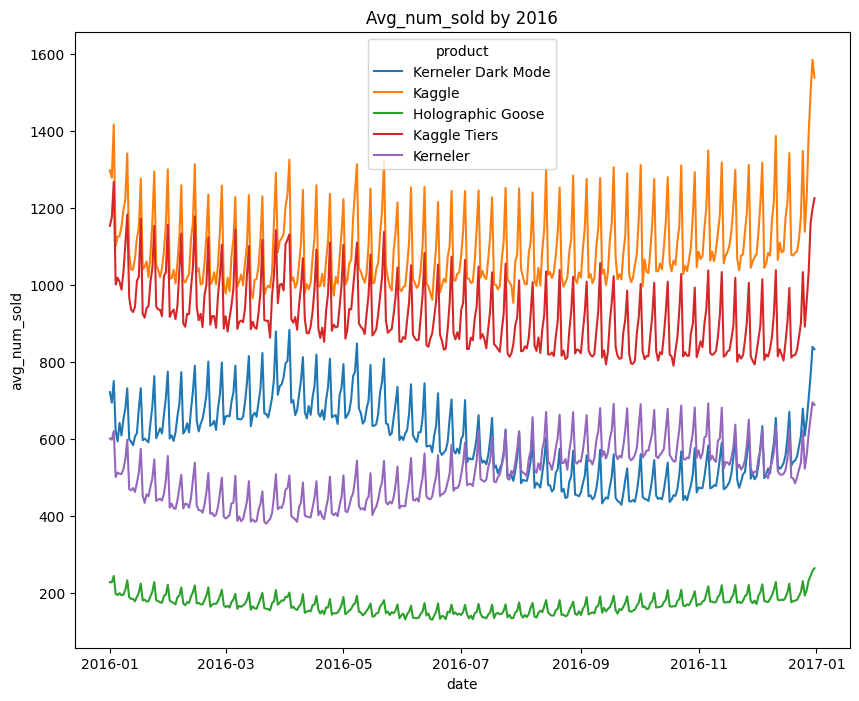

In [74]:
for i in list_year:
    plt.figure(figsize=(10,8))
    sns.lineplot(data=result.filter(pl.col("año") == i),x='date',y='avg_num_sold',hue='product')
    plt.title(f'Avg_num_sold by {i}')
    plt.show()

## **Data Transformation**

In [75]:
le=LabelEncoder()
# Ajustar y transformar la columna categórica
df = df.with_columns(
    pl.Series(
        name="country",
        values=le.fit_transform(df["country"].to_list())
    )
)

df = df.with_columns(
    pl.Series(
        name="product",
        values=le.fit_transform(df["product"].to_list())
    )
)

df = df.with_columns(
    pl.Series(
        name="store",
        values=le.fit_transform(df["store"].to_list())
    )
)

df

shape: (221_259, 17)
┌────────┬────────────┬─────────┬───────┬───┬─────────────┬───────────┬──────────┬──────────┐
│ id     ┆ date       ┆ country ┆ store ┆ … ┆ Month_Sin   ┆ Month_Cos ┆ Year_Sin ┆ Year_Cos │
│ ---    ┆ ---        ┆ ---     ┆ ---   ┆   ┆ ---         ┆ ---       ┆ ---      ┆ ---      │
│ i64    ┆ date       ┆ i64     ┆ i64   ┆   ┆ f64         ┆ f64       ┆ f64      ┆ f64      │
╞════════╪════════════╪═════════╪═══════╪═══╪═════════════╪═══════════╪══════════╪══════════╡
│ 1      ┆ 2010-01-01 ┆ 0       ┆ 0     ┆ … ┆ 0.5         ┆ 0.866025  ┆ 0.781831 ┆ 0.62349  │
│ 2      ┆ 2010-01-01 ┆ 0       ┆ 0     ┆ … ┆ 0.5         ┆ 0.866025  ┆ 0.781831 ┆ 0.62349  │
│ 3      ┆ 2010-01-01 ┆ 0       ┆ 0     ┆ … ┆ 0.5         ┆ 0.866025  ┆ 0.781831 ┆ 0.62349  │
│ 4      ┆ 2010-01-01 ┆ 0       ┆ 0     ┆ … ┆ 0.5         ┆ 0.866025  ┆ 0.781831 ┆ 0.62349  │
│ 5      ┆ 2010-01-01 ┆ 0       ┆ 2     ┆ … ┆ 0.5         ┆ 0.866025  ┆ 0.781831 ┆ 0.62349  │
│ …      ┆ …          ┆ …       ┆ …     ┆ … ┆ …           ┆ …         ┆ …        ┆ …        │
│ 230125 ┆ 2016-12-31 ┆ 5       ┆ 1     ┆ … ┆ -2.4493e-16 ┆ 1.0       ┆ 0.0      ┆ 1.0      │
│ 230126 ┆ 2016-12-31 ┆ 5       ┆ 1     ┆ … ┆ -2.4493e-16 ┆ 1.0       ┆ 0.0      ┆ 1.0      │
│ 230127 ┆ 2016-12-31 ┆ 5       ┆ 1     ┆ … ┆ -2.4493e-16 ┆ 1.0       ┆ 0.0      ┆ 1.0      │
│ 230128 ┆ 2016-12-31 ┆ 5       ┆ 1     ┆ … ┆ -2.4493e-16 ┆ 1.0       ┆ 0.0      ┆ 1.0      │
│ 230129 ┆ 2016-12-31 ┆ 5       ┆ 1     ┆ … ┆ -2.4493e-16 ┆ 1.0       ┆ 0.0      ┆ 1.0      │
└────────┴────────────┴─────────┴───────┴───┴─────────────┴───────────┴──────────┴──────────┘

In [76]:
# Eliminar las columnas "date" e "id"
df = df.drop(["date", "id"],axis=1)

## **Model Building**

In [78]:
X= df.drop(['num_sold'])
y = df['num_sold']

In [96]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()

# Si X_train y X_val son DataFrames de Polars, conviértelos también
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()

In [100]:
# Crear el modelo LGBMRegressor
model = LGBMRegressor(
    boosting_type= 'gbdt',
    objective='regression',
    n_estimators=993, 
    learning_rate= 0.12495670226205524, 
    max_depth= 10, 
    reg_alpha= 0.010957086224664707, 
    lambda_l2= 0.0002108222239665648, 
    min_child_samples= 72, 
    colsample_bytree= 0.8262764747341683, 
    subsample= 0.6304688949586668
)

# Entrenar el modelo
model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_val, y_val)], 
    eval_metric="MAE",
)
# Predecir en el conjunto de validación
y_pred = model.predict(X_val)

# Calcular el error cuadrático medio (RMSE)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = np.sqrt(mean_absolute_error(y_val, y_pred))
print(f"RMSE en el conjunto de validación: {rmse:.4f}")
print(f"MAE en el conjunto de validación: {mae:.4f}")

RMSE en el conjunto de validación: 55.8823
MAE en el conjunto de validación: 5.8412


* RMSE (Root Mean Squared Error): 55.8823

Esto mide el error promedio al cuadrado y luego se aplica la raíz cuadrada, lo que significa que penaliza más los errores grandes.
En este caso, el modelo tiene un error promedio de 55.88 unidades, lo cual sigue siendo razonable respecto a la media del target (752.53).

* MAE (Mean Absolute Error): 5.8412

Esta métrica mide el error promedio en valores absolutos, sin penalizar los errores grandes de manera desproporcionada.
Un MAE de 5.84 unidades indica que, en promedio, el modelo predice con una desviación muy baja respecto a los valores reales.